# V3: check neuralnet representation capacity 2layer

In [1]:
import matplotlib.pyplot as plt

In [2]:
def target_function1(x):
    return torch.exp(-x*4)*torch.cos(x*20)
def get_data(fn,N):
    x = torch.rand(N)
    y = fn(x)
    return x,y
def choice(x,y,N):
    perm = torch.randperm(x.size(0))
    idx = perm[:N]
    return x[idx],y[idx]

In [3]:
import torch

In [4]:
x = torch.rand(1000)
y = target_function1(x)

In [7]:
def nm(x):
    if 'cpu' in x.device.type:
        return x.detach().numpy()
    else:
        return x.detach().cpu().numpy()

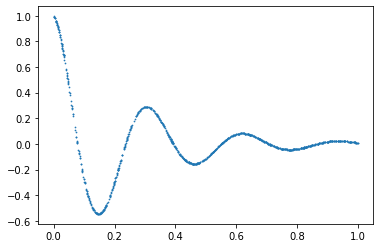

In [8]:
plt.scatter(nm(x),nm(y),s=0.5)

## find minmal model which can fit this example

In [15]:
import torch.nn as nn
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)
    def forward(self,x):
        h_relu1 = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu1).clamp(min=0)
        y_pred = self.linear3(h_relu2)
        return y_pred
class TwoLayerNetRes(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNetRes, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)
    def forward(self,x):
        h_relu1 = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu1).clamp(min=0)
        y_pred = self.linear3(h_relu2+h_relu1)
        return y_pred

## find best by optuna

In [47]:
import optuna
import time

In [69]:
def objective(trial):
    H = trial.suggest_int('H', 10, 1000)
    MAX_ITR = 50000
    b_size = 128
    device = torch.device("cuda:0")
    model = TwoLayerNetRes(1,H,1).to(device)
    optim = torch.optim.Adadelta(model.parameters())
    log = []
    x = torch.rand(1000).to(device)
    y = target_function1(x).to(device)
    for _ in range(5):
        st = time.time()
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,b_size)
            y_ = yy.unsqueeze(-1)
            y_pred = model(xx.unsqueeze(-1))
            loss =torch.pow(y_pred-y_,2).mean()
            optim.zero_grad()
            loss.backward()
            optim.step()
            # print(loss.item())
            if time.time()-st > 10:
                break
        y_pred = model(x.unsqueeze(-1))
        y_ = y.unsqueeze(-1)
        loss =torch.pow(y_pred-y_,2).mean()
        log.append(loss.item())    
    return np.mean(log)

In [70]:
study = optuna.create_study()

In [71]:
study.optimize(objective, n_trials=20)

[I 2019-07-13 23:35:37,802] Finished trial#0 resulted in value: 0.0004982334328815341. Current best value is 0.0004982334328815341 with parameters: {'H': 854}.
[I 2019-07-13 23:36:27,958] Finished trial#1 resulted in value: 0.002322783425915986. Current best value is 0.0004982334328815341 with parameters: {'H': 854}.
[I 2019-07-13 23:37:18,119] Finished trial#2 resulted in value: 0.00035398119216552005. Current best value is 0.00035398119216552005 with parameters: {'H': 725}.
[I 2019-07-13 23:38:08,274] Finished trial#3 resulted in value: 0.001074537135718856. Current best value is 0.00035398119216552005 with parameters: {'H': 725}.
[I 2019-07-13 23:38:58,429] Finished trial#4 resulted in value: 0.0013792312471196055. Current best value is 0.00035398119216552005 with parameters: {'H': 725}.
[I 2019-07-13 23:39:48,608] Finished trial#5 resulted in value: 0.0003689299206598662. Current best value is 0.00035398119216552005 with parameters: {'H': 725}.
[I 2019-07-13 23:40:38,779] Finished 

In [91]:
def objective(trial):
    H = trial.suggest_int('H', 500, 750)
    MAX_ITR = 50000
    b_size = 128
    device = torch.device("cuda:2")
    model = TwoLayerNetRes(1,H,1).to(device)
    optim = torch.optim.Adadelta(model.parameters())
    log = []
    x = torch.rand(1000).to(device)
    y = target_function1(x).to(device)
    for _ in range(5):
        st = time.time()
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,b_size)
            y_ = yy.unsqueeze(-1)
            y_pred = model(xx.unsqueeze(-1))
            loss =torch.pow(y_pred-y_,2).mean()
            optim.zero_grad()
            loss.backward()
            optim.step()
            # print(loss.item())
            if time.time()-st > 10:
                break
        y_pred = model(x.unsqueeze(-1))
        y_ = y.unsqueeze(-1)
        loss =torch.pow(y_pred-y_,2).mean()
        log.append(loss.item())    
    return np.mean(log)
study2 = optuna.create_study()
study2.optimize(objective, n_trials=20)

[I 2019-07-14 09:49:00,785] Finished trial#0 resulted in value: 0.0011014348303433508. Current best value is 0.0011014348303433508 with parameters: {'H': 683}.
[I 2019-07-14 09:49:50,952] Finished trial#1 resulted in value: 0.00011354719172231852. Current best value is 0.00011354719172231852 with parameters: {'H': 594}.
[I 2019-07-14 09:50:41,120] Finished trial#2 resulted in value: 0.0006815928863943554. Current best value is 0.00011354719172231852 with parameters: {'H': 594}.
[I 2019-07-14 09:51:31,287] Finished trial#3 resulted in value: 0.0015269106777850538. Current best value is 0.00011354719172231852 with parameters: {'H': 594}.
[I 2019-07-14 09:52:21,467] Finished trial#4 resulted in value: 0.000771510363847483. Current best value is 0.00011354719172231852 with parameters: {'H': 594}.
[I 2019-07-14 09:53:11,656] Finished trial#5 resulted in value: 0.0005436846811790019. Current best value is 0.00011354719172231852 with parameters: {'H': 594}.
[I 2019-07-14 09:54:01,830] Finishe

Text(0, 0.5, 'MSE in 10 sec (10trial)')

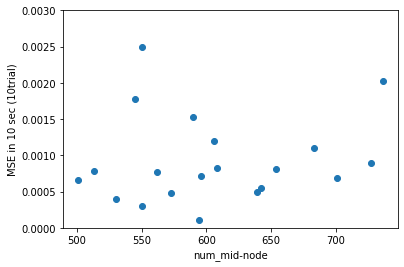

In [94]:
df2 = study2.trials_dataframe()
plt.scatter(df2.params.H,df2.value)
plt.ylim(0,0.003)
plt.xlabel('num_mid-node')
plt.ylabel('MSE in 10 sec (10trial)')

In [87]:
study.best_params

{'H': 725}

In [83]:
df = study.trials_dataframe()

In [88]:
import numpy as np

Text(0, 0.5, 'MSE in 10 sec (10trial)')

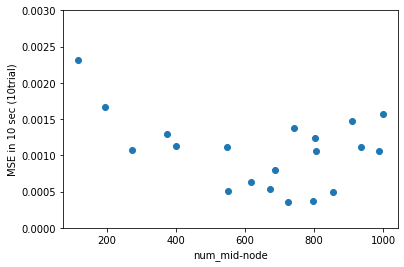

In [89]:
plt.scatter(df.params.H,df.value)
plt.ylim(0,0.003)
plt.xlabel('num_mid-node')
plt.ylabel('MSE in 10 sec (10trial)')

## naive and visualize

In [45]:
MAX_ITR = 10000
H = 10000
b_size = 128
device = torch.device("cuda:1")

model = SimpleNet(1,H,1).to(device)
optim = torch.optim.Adadelta(model.parameters())
x = x.to(device)
y = y.to(device)
log = []
for i in range(MAX_ITR):
    xx,yy = choice(x,y,b_size)
    y_ = yy.unsqueeze(-1)
    y_pred = model(xx.unsqueeze(-1))
    loss =torch.pow(y_pred-y_,2).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(loss.item())
    log.append(loss.item())

0.08414728939533234
78.75802612304688
14.43208122253418
10.46932601928711
9.838682174682617
10.396242141723633
9.847512245178223
9.520103454589844
9.207992553710938
10.21894645690918
11.588160514831543
13.137774467468262
14.768198013305664
16.999780654907227
18.253368377685547
19.833866119384766
21.312044143676758
21.928428649902344
22.972373962402344
25.17304039001465
25.808055877685547
26.187910079956055
25.234291076660156
25.258007049560547
26.475845336914062
25.921539306640625
24.52682113647461
23.347707748413086
23.806480407714844
24.260848999023438
24.267925262451172
23.427738189697266
20.431594848632812
21.289949417114258
21.49955177307129
20.78963851928711
19.745420455932617
19.950695037841797
18.29629898071289
16.693359375
16.530433654785156
15.617997169494629
13.184688568115234
12.580163955688477
11.221632957458496
11.04468059539795
11.44729232788086
11.453827857971191
10.990402221679688
11.813199996948242
12.675006866455078
13.483272552490234
13.707735061645508
14.1355457305

0.6608266830444336
0.6320808529853821
0.479292631149292
0.4339635968208313
0.4056124687194824
0.4064123034477234
0.43959367275238037
0.41717684268951416
0.3600500822067261
0.3384177088737488
0.30288076400756836
0.3079885244369507
0.36994490027427673
0.41211801767349243
0.4063163697719574
0.4052739441394806
0.4629794657230377
0.5009093284606934
0.5167760848999023
0.6373162269592285
0.7028712034225464
0.6724886894226074
0.7026903033256531
0.729148805141449
0.670336127281189
0.6621715426445007
0.6439371705055237
0.7934415340423584
0.8328292369842529
0.6734272241592407
0.5883394479751587
0.5833823084831238
0.5505573153495789
0.549744725227356
0.5340874791145325
0.4464154839515686
0.3735286593437195
0.347611665725708
0.284574419260025
0.2670527696609497
0.3061019778251648
0.31081295013427734
0.2540825605392456
0.3153038024902344
0.37610864639282227
0.3524415194988251
0.32200756669044495
0.3232731819152832
0.2832960784435272
0.27568790316581726
0.25745677947998047
0.24894914031028748
0.26577

0.03154674917459488
0.04347297549247742
0.07525904476642609
0.07652749121189117
0.1139029785990715
0.0752338320016861
0.05449453741312027
0.06521046161651611
0.09104612469673157
0.07969103008508682
0.08272725343704224
0.13237014412879944
0.14275115728378296
0.13786976039409637
0.18766355514526367
0.19339829683303833
0.16674283146858215
0.21143753826618195
0.15514284372329712
0.10954775661230087
0.09835657477378845
0.054129574447870255
0.04170326143503189
0.04930384084582329
0.06046755239367485
0.07070703059434891
0.04115322232246399
0.029279794543981552
0.020311051979660988
0.01464858464896679
0.014080611988902092
0.014353549107909203
0.011545858345925808
0.010122220031917095
0.00941634364426136
0.008347373455762863
0.0050462959334254265
0.006620188243687153
0.006310790311545134
0.007859509438276291
0.007587181404232979
0.005172404460608959
0.006805531680583954
0.0060579353012144566
0.006379792001098394
0.006456427276134491
0.005558502860367298
0.006632763426750898
0.007647110149264336

0.019499456509947777
0.03262536972761154
0.05209062248468399
0.04150182753801346
0.03008798509836197
0.010051995515823364
0.009115636348724365
0.008476733230054379
0.004791479092091322
0.00782366655766964
0.00967404805123806
0.01689114421606064
0.02692721039056778
0.02588532865047455
0.026614073663949966
0.033752139657735825
0.04903751611709595
0.06407136470079422
0.10032331943511963
0.06714415550231934
0.04712866246700287
0.04602891206741333
0.04526384919881821
0.013478991575539112
0.011609615758061409
0.007662806194275618
0.007933524437248707
0.01670987531542778
0.031114134937524796
0.030155885964632034
0.045265041291713715
0.05220112204551697
0.03828691691160202
0.029620841145515442
0.045544423162937164
0.019397664815187454
0.012354851700365543
0.009888841770589352
0.013675998896360397
0.017674867063760757
0.019852597266435623
0.01389366015791893
0.019572913646697998
0.0145990289747715
0.02205836959183216
0.03821614384651184
0.025935789570212364
0.03363822400569916
0.025982957333326

0.008023479953408241
0.003477603429928422
0.0020380252972245216
0.0015754291089251637
0.0016761475708335638
0.001462035346776247
0.0014205480692908168
0.001415187492966652
0.001546579645946622
0.0018019219860434532
0.0020060460083186626
0.002162966411560774
0.0020519329700618982
0.0017714519053697586
0.0015100791351869702
0.0020083049312233925
0.0029710340313613415
0.005167724564671516
0.0036941063590347767
0.0027010543271899223
0.0031201797537505627
0.006821942050009966
0.02475772798061371
0.035649821162223816
0.02544734627008438
0.008991179056465626
0.009631341323256493
0.010337249375879765
0.005641484633088112
0.005133301019668579
0.006093200296163559
0.005105246789753437
0.003887352766469121
0.0038795149885118008
0.003607435617595911
0.003577193943783641
0.003111343365162611
0.0034235597122460604
0.004066651687026024
0.004269812256097794
0.0028832373209297657
0.00274804700165987
0.003743775188922882
0.007239836733788252
0.011111004278063774
0.0135947335511446
0.019761722534894943
0

0.0017499946989119053
0.0018511605449020863
0.0024436884559690952
0.0024334555491805077
0.003257445991039276
0.0027283020317554474
0.002240243833512068
0.0026422820519655943
0.002500775270164013
0.003950370009988546
0.011991934850811958
0.01030104048550129
0.002091033849865198
0.001728910836391151
0.0024939286522567272
0.0028595966286957264
0.0021166729275137186
0.0026696580462157726
0.0020202649757266045
0.0027308028656989336
0.0023496574722230434
0.0028141476213932037
0.008191224187612534
0.02013874426484108
0.029281524941325188
0.02881087362766266
0.005237489938735962
0.006325326859951019
0.007720919791609049
0.005263743922114372
0.00652855820953846
0.013624576851725578
0.009731819853186607
0.015349640510976315
0.01403764821588993
0.014684401452541351
0.017611920833587646
0.0331968255341053
0.06025533005595207
0.058261651545763016
0.03188275545835495
0.008044274523854256
0.006258969195187092
0.007806106470525265
0.009959707036614418
0.010656284168362617
0.010284287855029106
0.005896

0.004391764290630817
0.0026676016859710217
0.003274876158684492
0.003166941460222006
0.004581281915307045
0.0026993025094270706
0.0018953122198581696
0.0022998121567070484
0.0029141870327293873
0.003595558227971196
0.0037837140262126923
0.005458123050630093
0.006674516946077347
0.004688871093094349
0.002561155240982771
0.0023596181999891996
0.0029836080502718687
0.0029685506597161293
0.0023097337689250708
0.002564606722444296
0.0033059311099350452
0.00353328138589859
0.005058755166828632
0.0054228040389716625
0.0055524203926324844
0.0069658514112234116
0.010006352327764034
0.011524632573127747
0.01195390522480011
0.018169105052947998
0.015142541378736496
0.016759514808654785
0.024469735100865364
0.02596910670399666
0.01682291179895401
0.013710040599107742
0.013599928468465805
0.03129070997238159
0.059689175337553024
0.07931899279356003
0.1199011504650116
0.10613232105970383
0.015588004142045975
0.012662749737501144
0.009684409946203232
0.008745959028601646
0.004314588848501444
0.004767

0.004252486862242222
0.003901309799402952
0.0033898865804076195
0.002402069978415966
0.0017205472104251385
0.002469266066327691
0.0033450042828917503
0.0023123957216739655
0.0033877557143568993
0.003913309425115585
0.001984173199161887
0.002303505316376686
0.0031472088303416967
0.0047620427794754505
0.006657896563410759
0.013261687010526657
0.012373464182019234
0.009219885803759098
0.01191694661974907
0.016326162964105606
0.014949366450309753
0.008661853149533272
0.004517062567174435
0.0014476838987320662
0.0014907080912962556
0.0018464791355654597
0.0019043537322431803
0.0031167054548859596
0.007756995968520641
0.017095861956477165
0.01119091734290123
0.005897908471524715
0.009064529091119766
0.006843165494501591
0.007704087998718023
0.013482343405485153
0.0070602670311927795
0.004691997077316046
0.010385111905634403
0.0216933973133564
0.02186347171664238
0.004528019577264786
0.0047581372782588005
0.006067410111427307
0.01205727644264698
0.010090608149766922
0.005859409458935261
0.005

0.00400093849748373
0.002453685738146305
0.001692374818958342
0.0020977770909667015
0.0022964361123740673
0.0022893878631293774
0.0012105123605579138
0.0013856884324923158
0.0016136686317622662
0.0026747076772153378
0.004935798235237598
0.006860669236630201
0.0023289769887924194
0.0031924531795084476
0.004863406997174025
0.004586146213114262
0.004572821315377951
0.00923849269747734
0.01587502472102642
0.014475422911345959
0.021434340626001358
0.020555514842271805
0.01612825319170952
0.018931634724140167
0.015316281467676163
0.013999471440911293
0.007166544906795025
0.008581824600696564
0.00841850508004427
0.01298739854246378
0.025377854704856873
0.039512380957603455
0.0313052199780941
0.019716061651706696
0.012661992572247982
0.005501267500221729
0.00633019395172596
0.006580882240086794
0.00585913984104991
0.0043510389514267445
0.005480664782226086
0.010791794396936893
0.015199280343949795
0.010876728221774101
0.010223879478871822
0.0037228763103485107
0.0033371374011039734
0.004168657

0.006031484808772802
0.009653309360146523
0.010984811931848526
0.01091265119612217
0.010044515132904053
0.00981157086789608
0.02191108465194702
0.022059841081500053
0.017555436119437218
0.017580382525920868
0.01792585477232933
0.014816418290138245
0.007400870323181152
0.004577845335006714
0.0046727159060537815
0.004518328234553337
0.0049885353073477745
0.004186579957604408
0.003334742970764637
0.0036320516373962164
0.004832628648728132
0.0037553035654127598
0.0031723040156066418
0.002617828780785203
0.0024267167318612337
0.002167775761336088
0.003150590695440769
0.002196983201429248
0.0010362309403717518
0.001237077871337533
0.0016229171305894852
0.0010816240683197975
0.0012395413359627128
0.0016604665433987975
0.002222289564087987
0.002327317837625742
0.0028377939015626907
0.002633714582771063
0.005082863382995129
0.006655230186879635
0.004228970035910606
0.003916797693818808
0.004946651868522167
0.006723360624164343
0.005486673675477505
0.008730985224246979
0.02036881074309349
0.0306

0.001320405164733529
0.002199749229475856
0.0015818289248272777
0.004019464366137981
0.004768380895256996
0.002871327567845583
0.006522964220494032
0.015171406790614128
0.017506513744592667
0.013233674690127373
0.016743982210755348
0.03245999664068222
0.04201199486851692
0.03624111786484718
0.025769202038645744
0.008232621476054192
0.00596785731613636
0.0052378359250724316
0.005148080177605152
0.004850424826145172
0.005168352276086807
0.00372912734746933
0.003477053251117468
0.004317128099501133
0.007320604752749205
0.005744630936533213
0.002457806607708335
0.0020574908703565598
0.002475010696798563
0.002946604508906603
0.0032103483099490404
0.0023842460941523314
0.0032039559446275234
0.005081569775938988
0.004775761626660824
0.0036324297543615103
0.005105476826429367
0.003417853731662035
0.005165702663362026
0.002697503659874201
0.003945131320506334
0.006468423176556826
0.010461939498782158
0.019440125674009323
0.007021316327154636
0.006831781007349491
0.00820818729698658
0.0078863520

0.01727978140115738
0.008722133934497833
0.007266199681907892
0.0061735850758850574
0.0025098389014601707
0.0019892072305083275
0.0014957457315176725
0.0019085414241999388
0.001937436405569315
0.002159717958420515
0.0013757062843069434
0.0010577836073935032
0.0014493773924186826
0.0030827829614281654
0.005100450944155455
0.010254517197608948
0.01851411536335945
0.01778455637395382
0.009136914275586605
0.005268251523375511
0.004079887177795172
0.0022970489226281643
0.0014473842456936836
0.0010731798829510808
0.0010741131845861673
0.0013260642299428582
0.0011077200761064887
0.0007566639687865973
0.0004776527639478445
0.0005781376967206597
0.0008047506562434137
0.0010873069986701012
0.0013115620240569115
0.0012666299007833004
0.0013486073585227132
0.0020004762336611748
0.0026289592497050762
0.0027684965170919895
0.003777358215302229
0.007579923141747713
0.004228701815009117
0.0018651913851499557
0.0038361193146556616
0.006972591392695904
0.01063762791454792
0.012569737620651722
0.01221610

0.0007914190646260977
0.0008983388543128967
0.0009556470322422683
0.0013907956890761852
0.001673715771175921
0.00240527605637908
0.0035141927655786276
0.004526307340711355
0.0032733227126300335
0.001854542177170515
0.0021791751496493816
0.002694192808121443
0.00202381843701005
0.001679235720075667
0.0015723068499937654
0.0016329761128872633
0.0023558074608445168
0.002772693522274494
0.006086976733058691
0.013523347675800323
0.01647719368338585
0.023322414606809616
0.022620845586061478
0.02044258639216423
0.012862598523497581
0.0058635566383600235
0.003959985915571451
0.0011318458709865808
0.000784764823038131
0.0006964905187487602
0.000762671756092459
0.0006779833929613233
0.0007884173537604511
0.0011102333664894104
0.001133758225478232
0.0019864002242684364
0.0017891695024445653
0.0014490906614810228
0.00121852639131248
0.0012281452072784305
0.0008082011481747031
0.0007673685904592276
0.00072775490116328
0.000536999839823693
0.0004139511729590595
0.00036075443495064974
0.0004453170113

0.0032911826856434345
0.006286595016717911
0.006428898312151432
0.010405606590211391
0.01649310439825058
0.012780440971255302
0.009464561007916927
0.0034789335913956165
0.002582971006631851
0.00211850693449378
0.0022456194274127483
0.00244325865060091
0.00270452001132071
0.0017394919414073229
0.0007551680319011211
0.0009740470559336245
0.0012260627700015903
0.0012572279665619135
0.0012604828225448728
0.0016378951258957386
0.001275746151804924
0.0010440739570185542
0.0011595669202506542
0.0014235525159165263
0.0015985784120857716
0.0019006640650331974
0.0024585467763245106
0.003363243769854307
0.003090812359005213
0.004178243689239025
0.005606385879218578
0.004906467627733946
0.005797410849481821
0.007505305111408234
0.007819191552698612
0.007080479525029659
0.008396122604608536
0.008886350318789482
0.009459908120334148
0.015383224934339523
0.018569763749837875
0.021517504006624222
0.013085572049021721
0.0029744943603873253
0.0017471193568781018
0.0020441249944269657
0.00244920281693339

0.0016624043928459287
0.0026586283929646015
0.004395445808768272
0.005073334090411663
0.006996018812060356
0.009667729958891869
0.002370093949139118
0.004329581744968891
0.010476580820977688
0.012061556801199913
0.020812291651964188
0.020855268463492393
0.013268118724226952
0.006658810656517744
0.009773566387593746
0.017691917717456818
0.011749586090445518
0.01824103109538555
0.042421694844961166
0.042813777923583984
0.026221800595521927
0.01956343650817871
0.016347821801900864
0.005162436980754137
0.0021749455481767654
0.0015949737280607224
0.0015028449706733227
0.001581443939357996
0.0015360661782324314
0.0007507000118494034
0.0007928797858767211
0.0007874136790633202
0.0006768915336579084
0.0007171966717578471
0.0006169546395540237
0.0007523237145505846
0.0006224539247341454
0.00034502119524404407
0.00040302143315784633
0.0003447249182499945
0.00031709676841273904
0.00029513530898839235
0.0003605306555982679
0.0003488024231046438
0.0004035954480059445
0.00040371110662817955
0.000329

0.004382843151688576
0.004944071173667908
0.003321699798107147
0.0024738849606364965
0.004155757836997509
0.009341040626168251
0.018867865204811096
0.011179503053426743
0.00718788243830204
0.006746682338416576
0.007351714186370373
0.0034639243967831135
0.00337163801304996
0.005189443007111549
0.007880060002207756
0.0055031063966453075
0.00294065335765481
0.0022685728035867214
0.0016742455773055553
0.0026299203746020794
0.003553131828084588
0.006461974233388901
0.00799139216542244
0.0030104932375252247
0.002402252983301878
0.0020783916115760803
0.0015117955626919866
0.000988195650279522
0.0010569742880761623
0.0009240780491381884
0.002208801917731762
0.00525699695572257
0.008190175518393517
0.007852831855416298
0.006575136911123991
0.008516417816281319
0.00739256152883172
0.005483658518642187
0.0072499895468354225
0.005941706709563732
0.010391153395175934
0.008497931994497776
0.012647428549826145
0.012905986979603767
0.009375721216201782
0.010620761662721634
0.018585458397865295
0.02130

0.000292559911031276
0.00029348445241339505
0.0005137889529578388
0.0005035242065787315
0.0008263266645371914
0.0010677312966436148
0.0017694762209430337
0.0012236429611220956
0.0019856346771121025
0.0026439365465193987
0.0039560492150485516
0.0066590458154678345
0.008886848576366901
0.015774043276906013
0.009222237393260002
0.004720393568277359
0.0019141160883009434
0.001555049791932106
0.00196186569519341
0.0022518401965498924
0.001823493279516697
0.0015240267384797335
0.0014324404764920473
0.0016488952096551657
0.0018238492775708437
0.002012805314734578
0.0017363817896693945
0.001731201889924705
0.0022055134177207947
0.0023935874924063683
0.001457997946999967
0.0007381287286989391
0.0006791962077841163
0.0007827124209143221
0.0009950713720172644
0.0019111630972474813
0.003626649733632803
0.0028385447803884745
0.0021634032018482685
0.0018273652531206608
0.001811046851798892
0.002482874784618616
0.003976910840719938
0.005019140429794788
0.0037469370290637016
0.003654452506452799
0.006

0.002525266259908676
0.004100241232663393
0.004151094704866409
0.0043138787150382996
0.008245542645454407
0.009952913038432598
0.008679241873323917
0.011075337417423725
0.019381409510970116
0.036363061517477036
0.03316272050142288
0.008271987549960613
0.012509232386946678
0.00791873037815094
0.0012395541416481137
0.001358688110485673
0.0015297202626243234
0.0016359133878722787
0.0022477740421891212
0.001619056100025773
0.0009857539553195238
0.0009020084980875254
0.0010525304824113846
0.0009394707740284503
0.0007362217293120921
0.000675464398227632
0.0006086598732508719
0.0005913510685786605
0.000726064492482692
0.0005651200190186501
0.0006007628398947418
0.0005687139928340912
0.000337195408064872
0.000370660301996395
0.00038766302168369293
0.00037266089930199087
0.0004346322675701231
0.0004204094875603914
0.0005715113366022706
0.0006747313891537488
0.0011970850173383951
0.001823963481001556
0.0013924420345574617
0.0010982677340507507
0.001405065879225731
0.001983668887987733
0.00399754

0.0009639243362471461
0.0008160838624462485
0.0007055537425912917
0.0008304386283271015
0.001084573450498283
0.001502301311120391
0.0005750500131398439
0.00031517917523160577
0.00027980218874290586
0.00043765560258179903
0.0005008370499126613
0.00048187849461100996
0.0004892405122518539
0.0005255985306575894
0.0006855365936644375
0.0011341983918100595
0.001556973671540618
0.0025029941461980343
0.004067670088261366
0.004985716659575701
0.004037255886942148
0.004261959344148636
0.004903803113847971
0.0053072660230100155
0.0035986918956041336
0.0033401455730199814
0.0012659525964409113
0.0019209629390388727
0.0019401834579184651
0.0008877882501110435
0.0009620863129384816
0.0006927110953256488
0.0011941873235628009
0.0011098713148385286
0.0011875114869326353
0.0014950083568692207
0.0022815000265836716
0.0038041670341044664
0.0035234959796071053
0.005355792120099068
0.005704415030777454
0.004712664056569338
0.006196150556206703
0.004351704381406307
0.005770681891590357
0.01554183755069971


0.0017690241802483797
0.0026373169384896755
0.001961750676855445
0.0031730057671666145
0.00505817448720336
0.0035806442610919476
0.0067422883585095406
0.008170435205101967
0.009595364332199097
0.02228625863790512
0.01750439964234829
0.01603728160262108
0.025594498962163925
0.0225012619048357
0.020994873717427254
0.018325449898838997
0.01411927305161953
0.024915024638175964
0.02675064466893673
0.024915112182497978
0.012891539372503757
0.007729139178991318
0.005088252946734428
0.0023975567892193794
0.002562399487942457
0.0021285410039126873
0.0014687050133943558
0.0013016450684517622
0.0008236978901550174
0.0006997906602919102
0.0004572509787976742
0.0003716517239809036
0.0003934379783459008
0.0003502720792312175
0.00034728922764770687
0.0003843254526145756
0.00030294281896203756
0.0003687224816530943
0.00031611660961061716
0.0003586706006899476
0.000244934723014012
0.00023374403826892376
0.00026698934379965067
0.0003191322321072221
0.0002818913199007511
0.0002816038322634995
0.000279299

0.0021251461002975702
0.0019994108006358147
0.0017185250762850046
0.0016585898119956255
0.0014817117480561137
0.002083613071590662
0.002283888403326273
0.002110037487000227
0.0020293714478611946
0.00177523132879287
0.0018157800659537315
0.0016764610772952437
0.0018133085686713457
0.0013845444191247225
0.0012641610810533166
0.00131732109002769
0.0018917780835181475
0.002851373516023159
0.004112857393920422
0.004999313037842512
0.0033329252619296312
0.0034318792168051004
0.0024101249873638153
0.002119197277352214
0.0031327928882092237
0.004882093518972397
0.0038134020287543535
0.0023535937070846558
0.003134598024189472
0.005319545976817608
0.008586999028921127
0.004045714624226093
0.002784155774861574
0.0033014975488185883
0.003962150774896145
0.00142195587977767
0.002366192638874054
0.002560289576649666
0.002959347330033779
0.003389449790120125
0.006002806127071381
0.009404964745044708
0.013136092573404312
0.007122786715626717
0.010148981586098671
0.023447450250387192
0.0176316481083631

0.0006489378865808249
0.0006521732429973781
0.001108895055949688
0.001289117382839322
0.001734334509819746
0.0024353116750717163
0.0024759036023169756
0.003709144424647093
0.0048036715015769005
0.006413833238184452
0.004294020123779774
0.0028694351203739643
0.0017175412504002452
0.004286372102797031
0.005410842597484589
0.005107557401061058
0.006142915226519108
0.00658910907804966
0.010078227147459984
0.010305728763341904
0.0032881235238164663
0.002756100380793214
0.0024398360401391983
0.0021187460515648127
0.0032786778174340725
0.0019116939511150122
0.0016369180520996451
0.0022651508916169405
0.0037650112062692642
0.006374603137373924
0.0049428073689341545
0.0053290072828531265
0.0036788885481655598
0.003895401256158948
0.0067961737513542175
0.004671304486691952
0.0038015893660485744
0.0035642734728753567
0.0067329006269574165
0.01874655671417713
0.021724173799157143
0.014716604724526405
0.013294657692313194
0.003821343183517456
0.0031550347339361906
0.0020038713701069355
0.0017498496

0.0019380053272470832
0.000883357017301023
0.00068154267501086
0.0005830720765516162
0.0006367515306919813
0.0008110051276162267
0.001057104323990643
0.0008344696834683418
0.0006162618519738317
0.0006373564247041941
0.0006027322961017489
0.0005005444400012493
0.0005294705042615533
0.0004749478539451957
0.0005235978751443326
0.0004945682012476027
0.0004560763482004404
0.00043669959995895624
0.00039503281004726887
0.0004821007023565471
0.00040915035060606897
0.00036532949889078736
0.00041927897837013006
0.00037414758116938174
0.00035670719807967544
0.00046148060937412083
0.00035596289671957493
0.0004499567439779639
0.0004767852951772511
0.00043015406117774546
0.00035251473309472203
0.0005347494152374566
0.0011189560173079371
0.0015541485045105219
0.0026697744615375996
0.003167340997606516
0.0039610848762094975
0.004193559288978577
0.0069544268772006035
0.00897938385605812
0.010373443365097046
0.007216274738311768
0.0042260996997356415
0.004296177998185158
0.005742345005273819
0.007832024

0.0009466445771977305
0.0008601846056990325
0.0006060669547878206
0.0006084988126531243
0.000672178459353745
0.0008128214394673705
0.0008558753761462867
0.0006005436880514026
0.0007643763674423099
0.000841963104903698
0.0010771381203085184
0.0011732673738151789
0.0013358378782868385
0.001306430553086102
0.0015136031433939934
0.0009950092062354088
0.0007908908883109689
0.0009977285517379642
0.0012582334456965327
0.0010884618386626244
0.000692438508849591
0.00030855159275233746
0.00037836842238903046
0.00031203078106045723
0.0003092160332016647
0.00028390661464072764
0.0002462979464326054
0.00022681316477246583
0.0002524676383472979
0.0002585180918686092
0.00026113068452104926
0.0002949323388747871
0.00030075045651756227
0.0002593928948044777
0.0002149874926544726
0.00020348696853034198
0.000258659798419103
0.0002317723847227171
0.0003409044584259391
0.0002547195181250572
0.00041276414413005114
0.0006396565004251897
0.0012892736122012138
0.0024741091765463352
0.0034677120856940746
0.0031

0.0015540503663942218

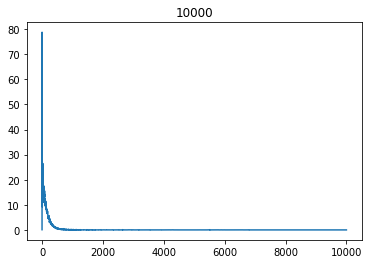

In [46]:
plt.plot(log)
plt.title('10000')
log[-1]

In [50]:
for parameter in model.parameters():
    print(parameter.shape)

torch.Size([10000, 1])
torch.Size([10000])
torch.Size([1, 10000])
torch.Size([1])


Text(0.5, 1.0, '10000')

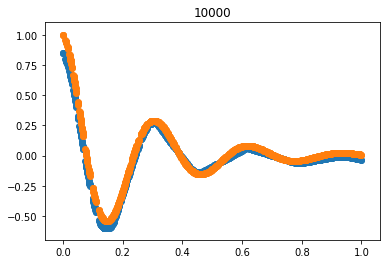

In [52]:
y_pred = model(x.unsqueeze(-1))
plt.scatter(nm(x),nm(y_pred))
plt.scatter(nm(x),nm(y))
plt.title('10000')

0.0009162608766928315

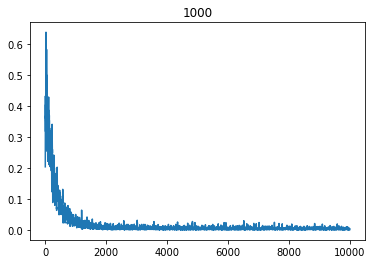

In [42]:
plt.plot(log)
plt.title('1000')
log[-1]

Text(0.5, 1.0, '1000')

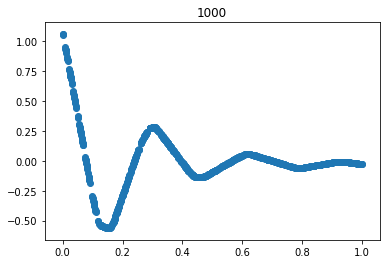

In [44]:
y_pred = model(x.unsqueeze(-1))
plt.scatter(nm(x),nm(y_pred))
# plt.scatter(nm(x),nm(y))
plt.title('1000')

0.0017236488638445735

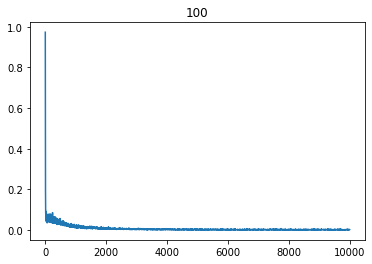

In [40]:
plt.plot(log)
plt.title('100')
log[-1]

Text(0.5, 1.0, '100')

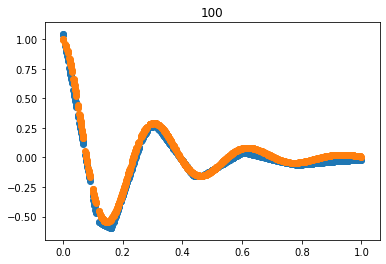

In [39]:
y_pred = model(x.unsqueeze(-1))
plt.scatter(nm(x),nm(y_pred))
plt.scatter(nm(x),nm(y))
plt.title('100')

Text(0.5, 1.0, '10')

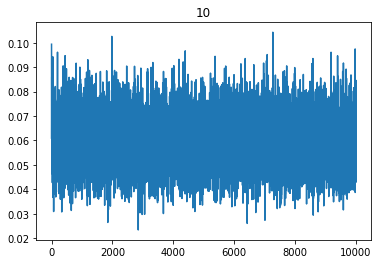

In [33]:
plt.plot(log)
plt.title('10')

Text(0.5, 1.0, '10')

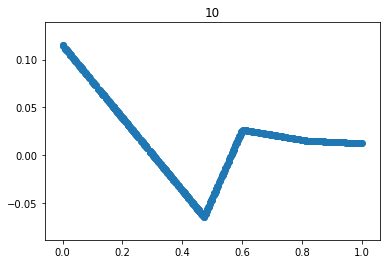

In [35]:
y_pred = model(x.unsqueeze(-1))
plt.scatter(nm(x),nm(y_pred))
plt.title('10')

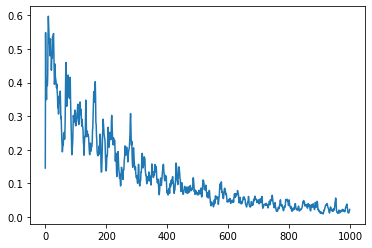

# ====== ragacy ======

In [97]:
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
import torch.nn as nn
class MultiheadThreeLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out,num_head):
        self.num_head = num_head
        super(MultiheadThreeLayerNet, self).__init__()
        self.linear1s = nn.ModuleList([torch.nn.Linear(D_in, H) for _ in range(self.num_head)])
        self.linear2s = nn.ModuleList([torch.nn.Linear(H, H) for _ in range(self.num_head)])
        self.linear3s = nn.ModuleList([torch.nn.Linear(H, D_out) for _ in range(self.num_head)])
        #self.linear3s = nn.ModuleList([torch.nn.Linear(H, D_out) for _ in range(self.num_head)])

    def forward(self, x): # input : (10000,1)
        h_relus = [li(x).clamp(min=0 ) for li in self.linear1s]
        h_relu2s = [li(hl).clamp(min=0) for li, hl in zip(self.linear2s,h_relus)]
        y_preds = [li(hl) for li, hl in zip(self.linear3s,h_relu2s)]
        #y_preds = [li(hl) for li, hl in zip(self.linear3s,h_relus)]
        return torch.cat(y_preds,dim=1).squeeze(-1) # output : (10000,num_head)

In [201]:
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
import torch.nn as nn
class MultiheadThreeLayerNetRes(torch.nn.Module):
    def __init__(self, D_in, H, D_out,num_head):
        self.num_head = num_head
        super(MultiheadThreeLayerNetRes, self).__init__()
        self.linear1s = nn.ModuleList([torch.nn.Linear(D_in, H) for _ in range(self.num_head)])
        self.linear2s = nn.ModuleList([torch.nn.Linear(H, H) for _ in range(self.num_head)])
        self.linear3s = nn.ModuleList([torch.nn.Linear(H, H) for _ in range(self.num_head)])
        self.linear4s = nn.ModuleList([torch.nn.Linear(H, D_out) for _ in range(self.num_head)])
        #self.linear3s = nn.ModuleList([torch.nn.Linear(H, D_out) for _ in range(self.num_head)])

    def forward(self, x): # input : (10000,1)
        h_relus = [li(x).clamp(min=0) for li in self.linear1s]
        h_relu2s = [li(hl).clamp(min=0) for li, hl in zip(self.linear2s,h_relus,)]
        h_relu3s = [li(hl2+hl).clamp(min=0) for li, hl2,hl in zip(self.linear3s,h_relu2s,h_relus)]
        y_preds = [li(hl3+hl2) for li, hl3,hl2 in zip(self.linear4s,h_relu3s,h_relu2s)]
        #y_preds = [li(hl) for li, hl in zip(self.linear3s,h_relus)]
        return torch.cat(y_preds,dim=1).squeeze(-1) # output : (10000,num_head)
    

MAX_ITR = 4000
class Multihead_EnsembleRes(object):
    def __init__(self,num_head,device,b_size=128,learning_rate=1e-3,H=100,to_next_th=0.01):
        self.device = device
        self.b_size=b_size
        self.to_next_th = to_next_th
        self.num_head = num_head
        self.model = MultiheadThreeLayerNetRes(1, H, 1,num_head).to(device)
        #self.optim = torch.optim.Adam(self.model.parameters(),lr=learning_rate)
        self.optim = torch.optim.Adadelta(self.model.parameters())
        
    def pred_mean(self,x): # (10000)
        return self.model(x.unsqueeze(1)).mean(dim=1) # (10000)
    
    def pred_unce(self,x): # (10000)
        return self.model(x.unsqueeze(1)).std(dim=1) # (10000)
    
    def pred(self,x): #(10000)
        return self.model(x.unsqueeze(1)) #(10000)
    
    def learn(self,x,y): # x:(itr,1), y:(itr,1)
        y_ = y.expand(y.shape[0],num_head) # (itr,num_head)
        x_ = x.unsqueeze(1)
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            y_pred = self.model(x_)
            loss =torch.pow(y_pred-y_,2).mean(dim=0).mean()#self.criterion(y_pred, y)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            if loss.item() < self.to_next_th:
                break
            if i == MAX_ITR-1:
                print('[warning] OVER MAX_ITR')
            
        print(loss.item())

In [196]:
def choice(x,y,N):
    perm = torch.randperm(x.size(0))
    idx = perm[:N]
    return x[idx],y[idx]

In [186]:
MAX_ITR = 4000
class Multihead_Ensemble(object):
    def __init__(self,num_head,device,b_size=128,learning_rate=1e-3,H=100,to_next_th=0.01):
        self.device = device
        self.b_size=b_size
        self.to_next_th = to_next_th
        self.num_head = num_head
        self.model = MultiheadThreeLayerNet(1, H, 1,num_head).to(device)
        #self.optim = torch.optim.Adam(self.model.parameters(),lr=learning_rate)
        self.optim = torch.optim.Adadelta(self.model.parameters())
        
    def pred_mean(self,x): # (10000)
        return self.model(x.unsqueeze(1)).mean(dim=1) # (10000)
    
    def pred_unce(self,x): # (10000)
        return self.model(x.unsqueeze(1)).std(dim=1) # (10000)
    
    def pred(self,x): #(10000)
        return self.model(x.unsqueeze(1)) #(10000)
    
    def learn(self,x,y): # x:(itr,1), y:(itr,1)
        y_ = y.expand(y.shape[0],num_head) # (itr,num_head)
        x_ = x.unsqueeze(1)
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            y_pred = self.model(x_)
            loss =torch.pow(y_pred-y_,2).mean(dim=0).mean()#self.criterion(y_pred, y)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            if loss.item() < self.to_next_th:
                break
            if i == MAX_ITR-1:
                print('[warning] OVER MAX_ITR')
            
        print(loss.item())

In [187]:
torch.pow(torch.rand(5).view(5,1).expand(5,2),2).mean(dim=0)

tensor([0.3091, 0.3091])

## model check

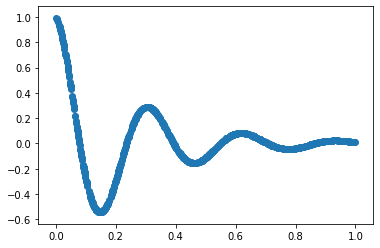

In [188]:
fn = target_function1
x,y = get_data(fn,cand)
plt.scatter(nm(x),nm(y))

# simple

[warning] OVER MAX_ITR
0.004765442572534084


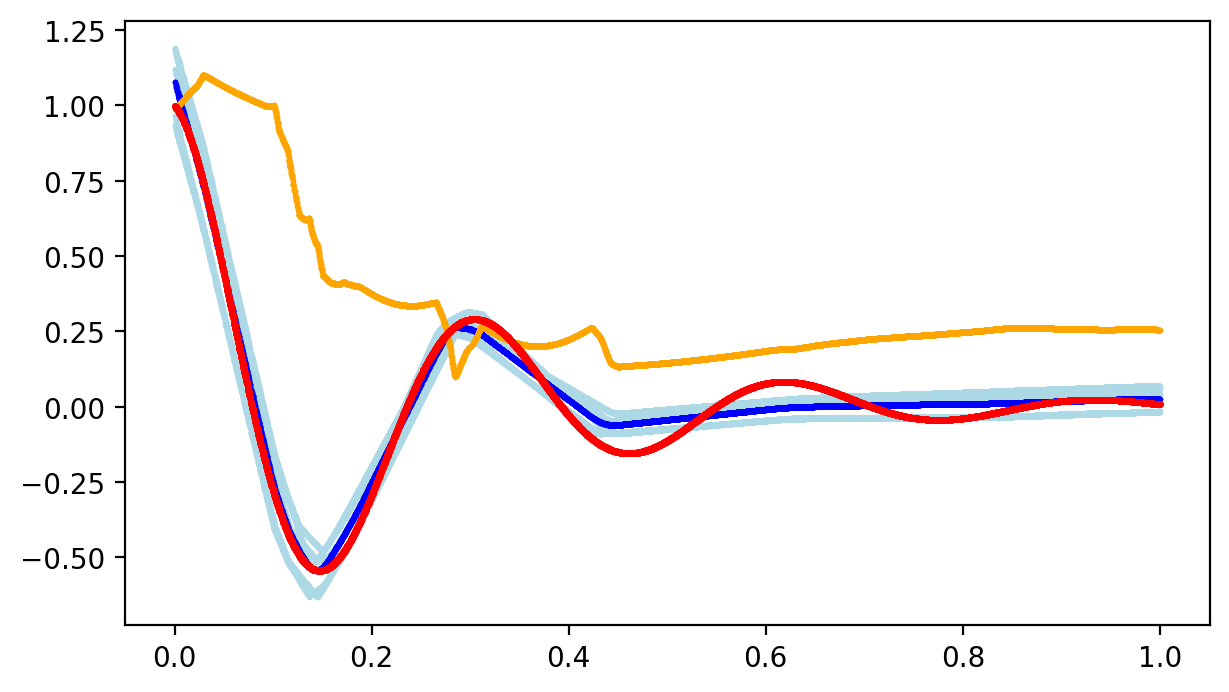

In [164]:
num_head=5
th = 0.0001
H = 100
model = Multihead_Ensemble(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.0073987259529531


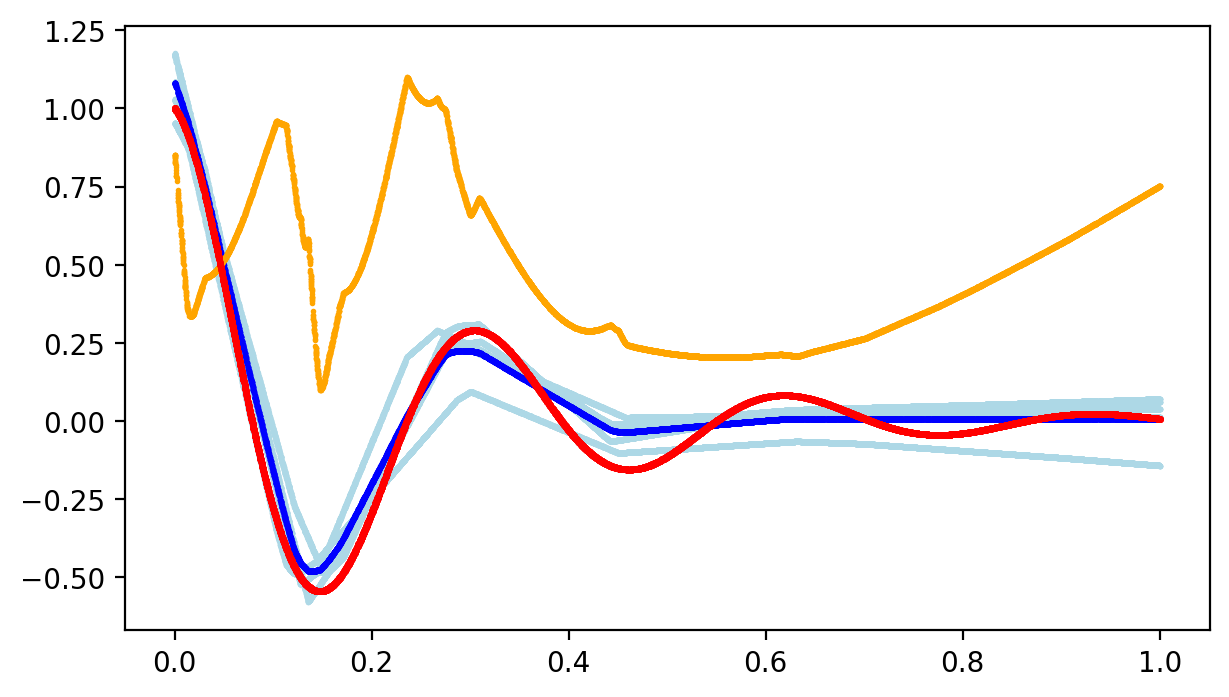

In [163]:
num_head=5
th = 0.0001
H = 20
model = Multihead_Ensemble(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

## add SGD

[warning] OVER MAX_ITR
0.004365223925560713


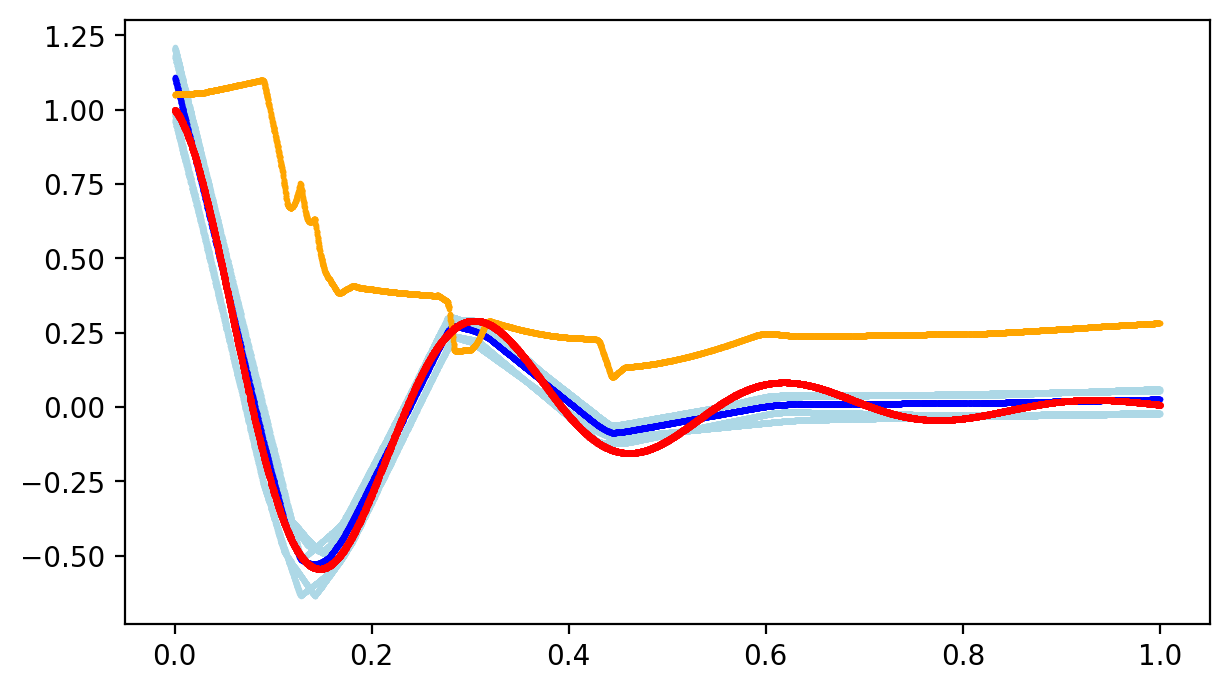

In [189]:
num_head=5
th = 0.0001
H = 100
model = Multihead_Ensemble(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

## Res

[warning] OVER MAX_ITR
0.003764860099181533


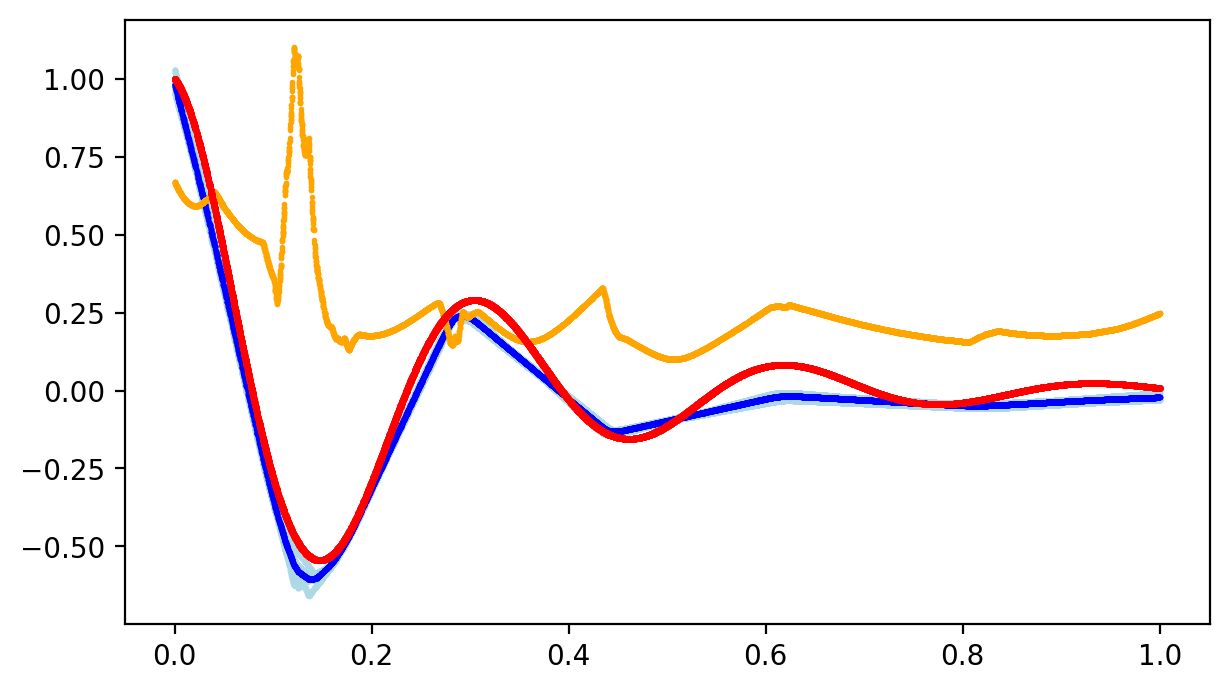

In [197]:
num_head=5
th = 0.0001
H = 100
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.003324431600049138


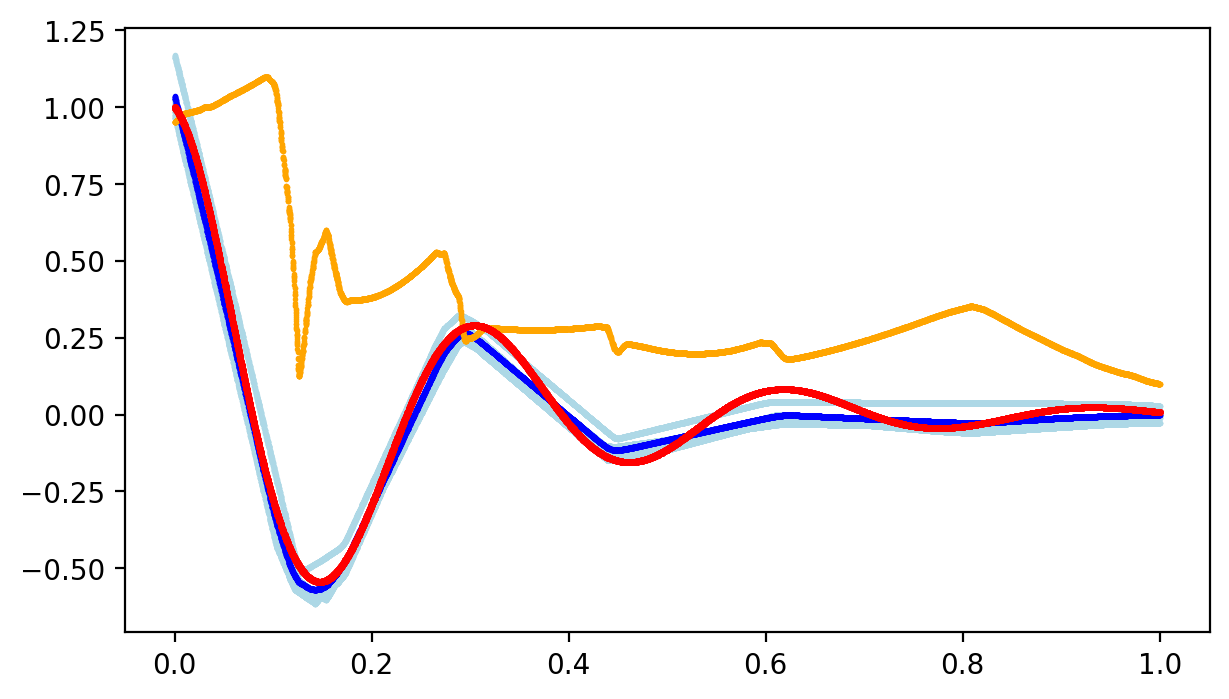

In [198]:
num_head=5
th = 0.0001
H = 50
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.002719550160691142


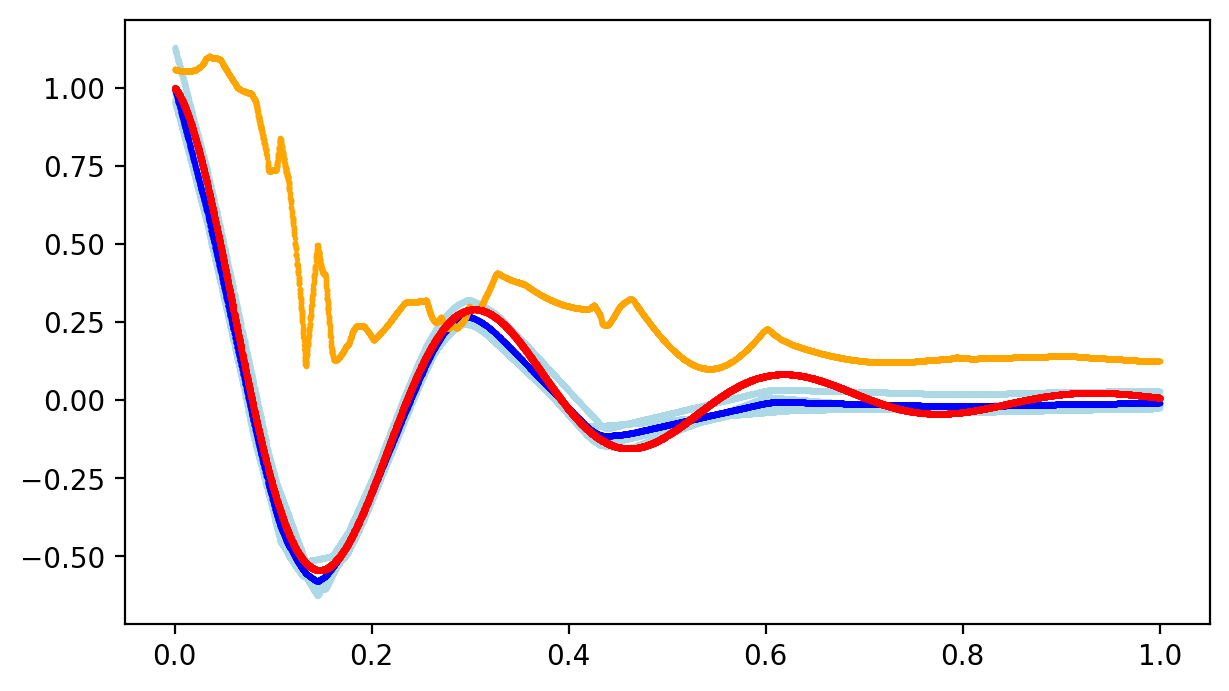

In [202]:
#more res
num_head=5
th = 0.0001
H = 50
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.002642221748828888


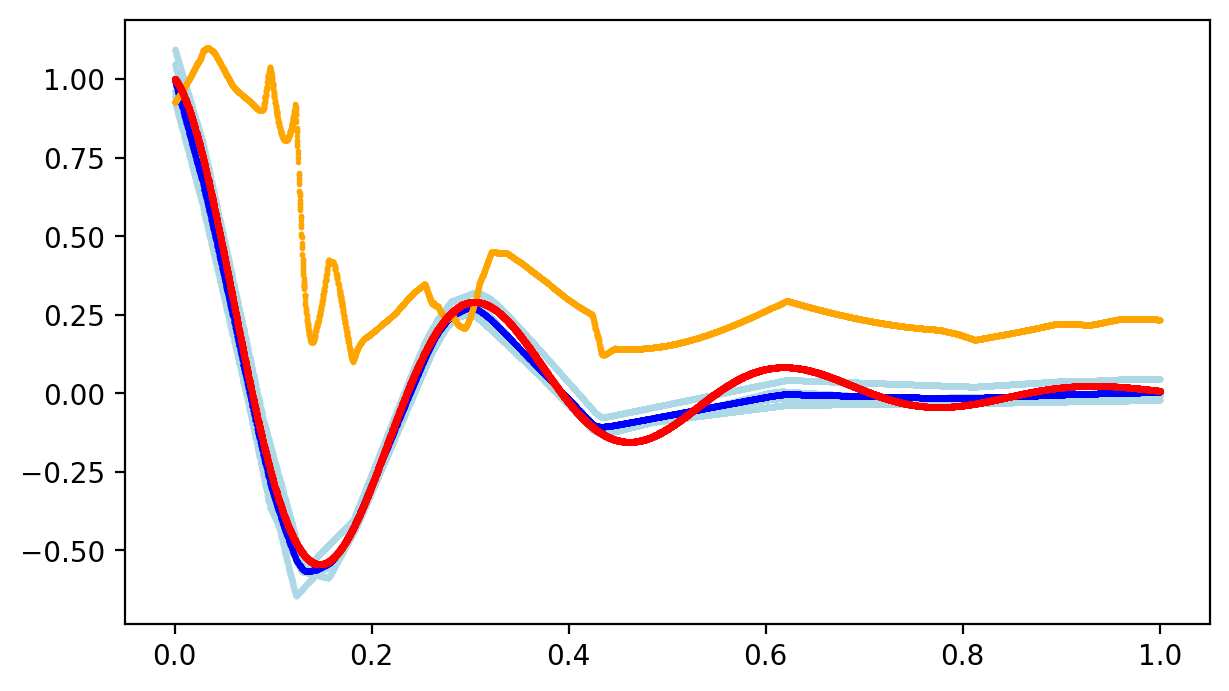

In [203]:
#more res
num_head=5
th = 0.0001
H = 20
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.002659764839336276


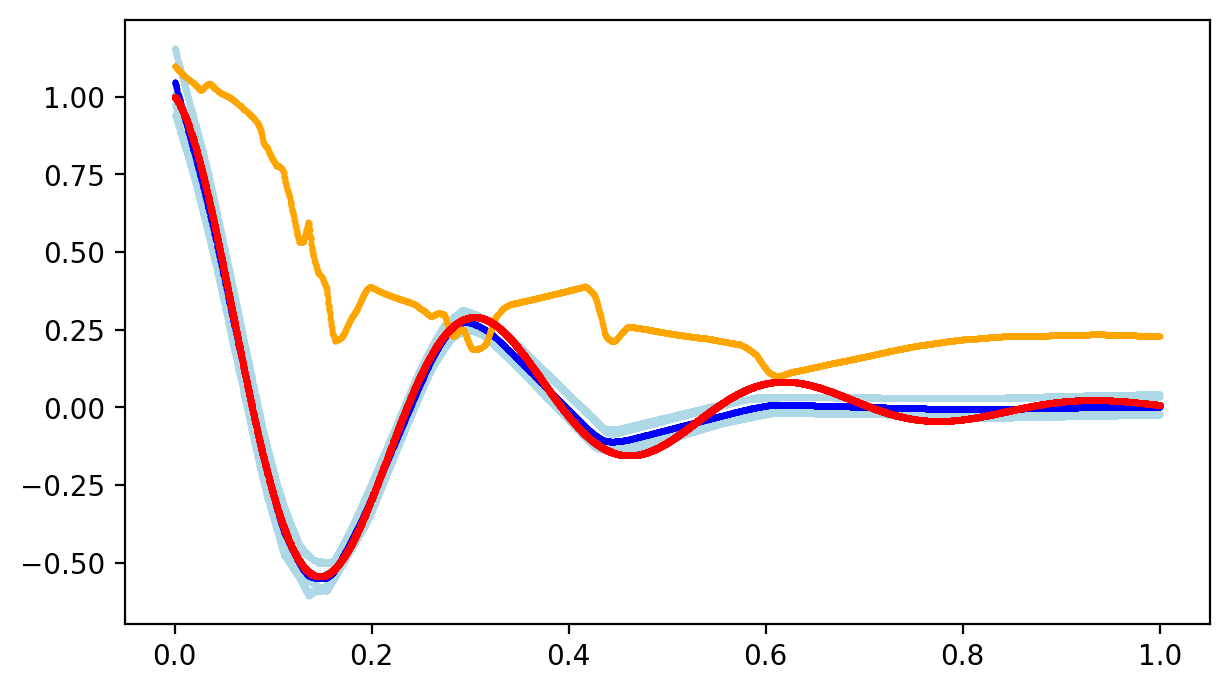

In [204]:
#more res
num_head=5
th = 0.0001
H = 100
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.029134472832083702


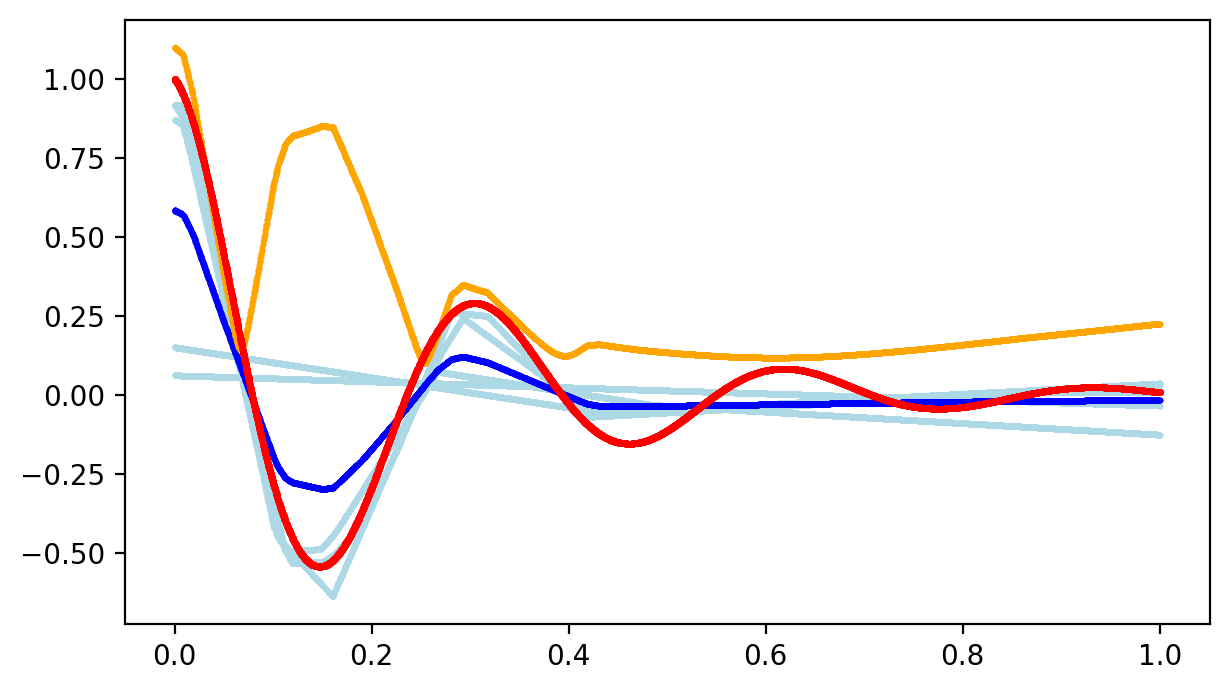

In [205]:
#more res
num_head=5
th = 0.0001
H = 5
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.0024641994386911392


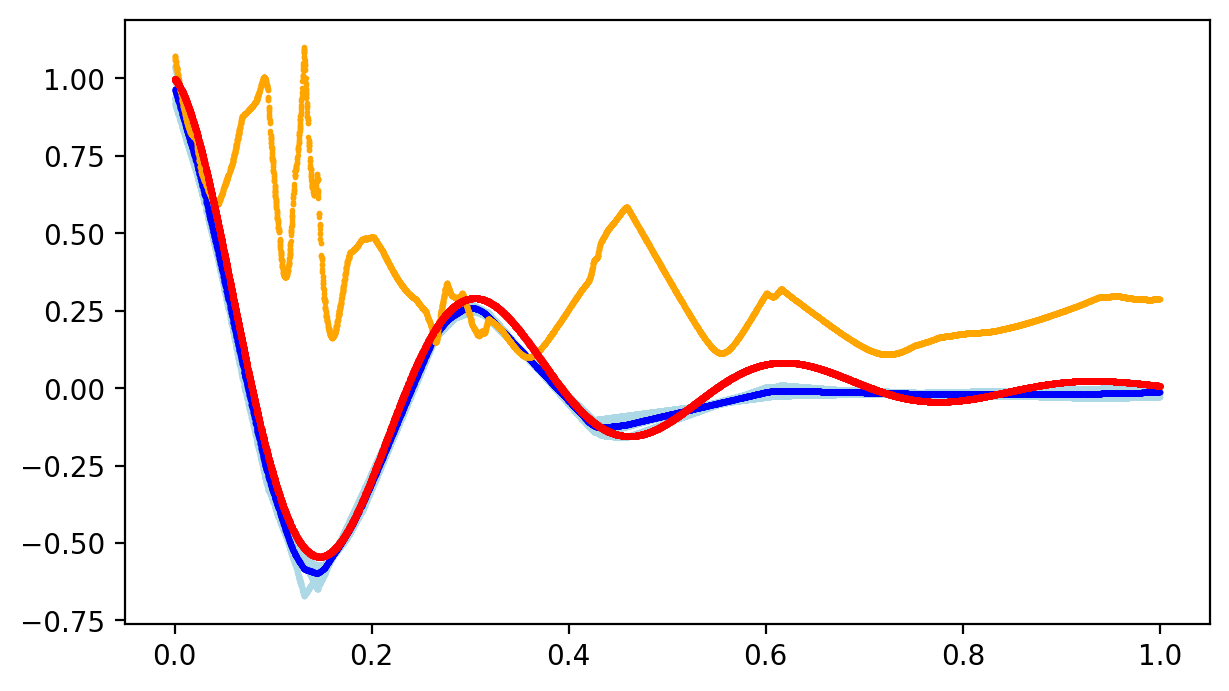

In [206]:
#more res
num_head=5
th = 0.0001
H = 20
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

[warning] OVER MAX_ITR
0.01066310703754425


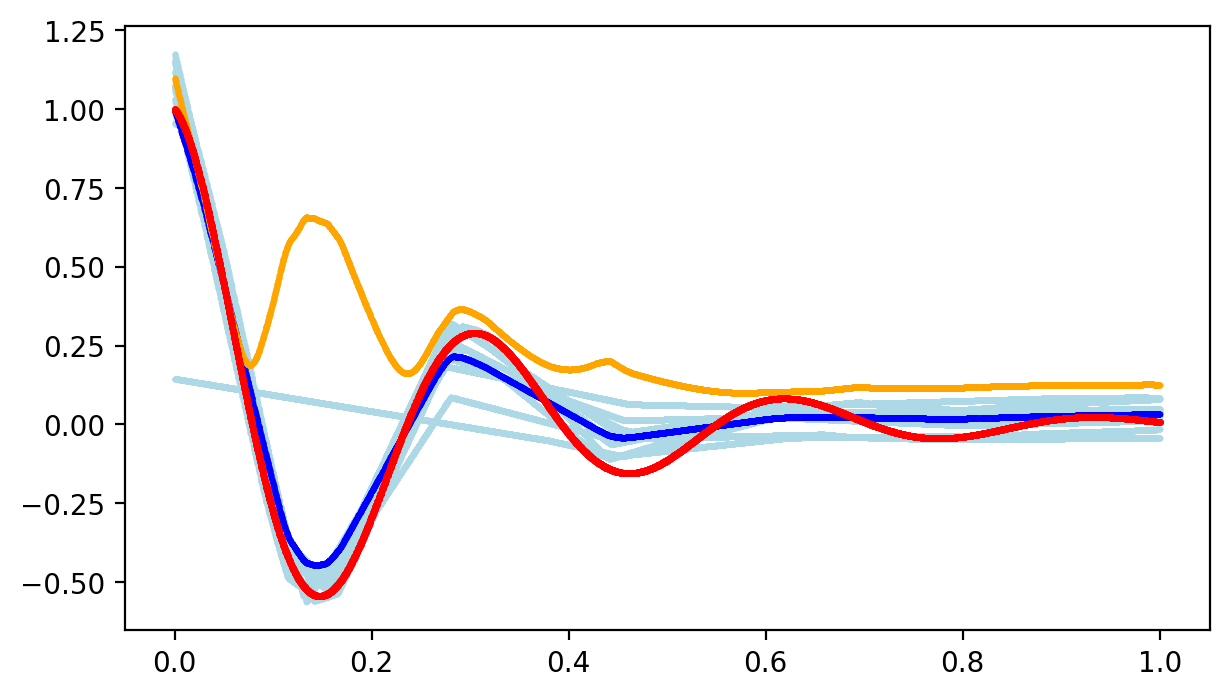

In [207]:
#more res
num_head=10
th = 0.0001
H = 20
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)
model.learn(x.to(device).unsqueeze(-1),y.to(device).unsqueeze(-1))

plt.figure(figsize=(7,4),dpi=200)
x, y = get_data(target_function1,10000)
x = x.to(device)
y = y.to(device)
y_hat = model.pred(x)
for i in range(num_head):
    plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
unc = nm(model.pred_unce(x))
plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
plt.scatter(nm(x),nm(y),s = 2,color='red')
plt.pause(0.05)

## Pseudo code

In [208]:
from IPython import display
from IPython.display import clear_output

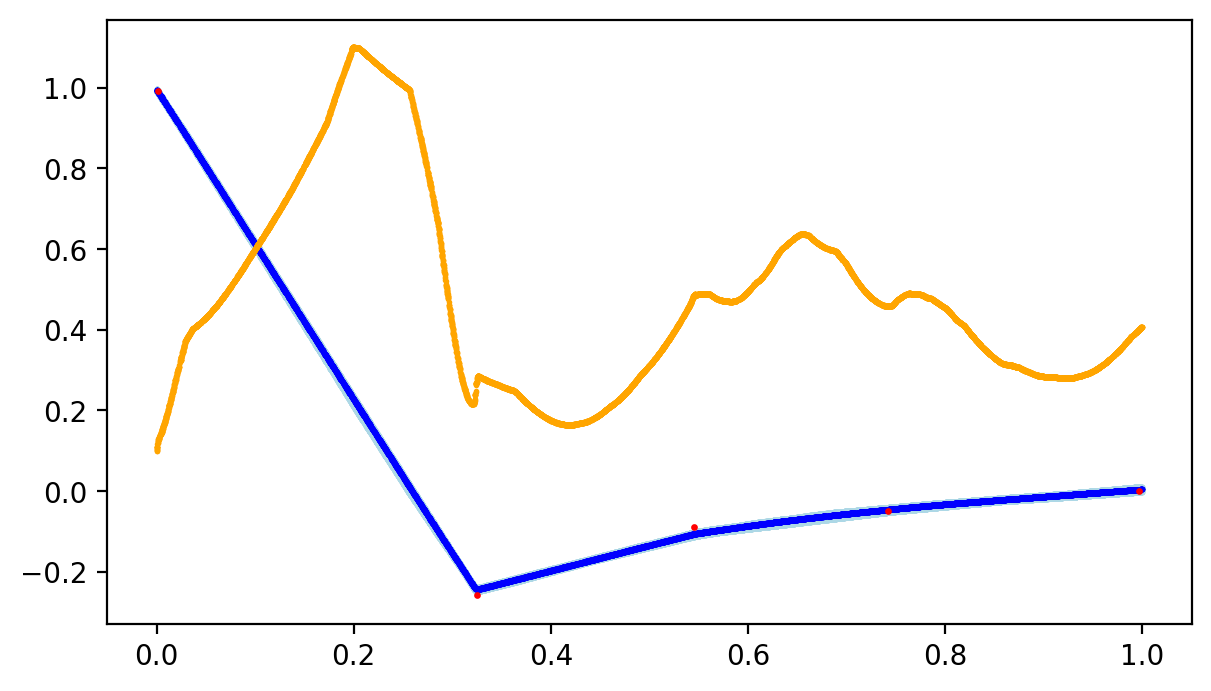

iteration: 5	

KeyboardInterrupt: 

In [90]:
cand = 1000
fn = target_function1
device = torch.device("cuda:1")
num_head=10
th = 0.0001
H = 100
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)

for i in range(1000):
    print('iteration:',i,end='\t')
    x,y = get_data(fn,cand) # (10000),(10000)
    x = x.to(device)
    max_id = model.pred_unce(x).argmax()
    if i == 0:
        train_data_x = x[max_id].view(1,1) 
        train_data_y = fn(x[max_id]).view(1,1)
    else:
        train_data_x = torch.cat((train_data_x,x[max_id].view(1,1))) # (i,1) -> (i+1)
        train_data_y = torch.cat((train_data_y,fn(x[max_id]).view(1,1)))
    model = Multihead_Ensemble(num_head,device,to_next_th=th,H=H)
    model.learn(train_data_x,train_data_y)
    
    # plot
    clear_output(wait=True)
    plt.figure(figsize=(7,4),dpi=200)
    x, y = get_data(target_function1,10000)
    x = x.to(device)
    y = y.to(device)
    y_hat = model.pred(x)
    for i in range(num_head):
        plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
    plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
    unc = nm(model.pred_unce(x))
    plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
    # plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
    plt.scatter(nm(train_data_x),nm(train_data_y),s = 2,color='red')
    plt.pause(0.05)

In [ ]:
N=64
cand = 100
fn = target_function1
device = torch.device("cuda:1")
num_head=10
model = Multihead_Ensemble(num_head,device,to_next_th=0.01,H=100,learning_rate=0.01)

for i in range(1000):
    print('iteration:',i,end='\t')
    x,y = get_data(fn,cand) # (10000),(10000)
    x = x.to(device)
    y = y.to(device)
    # max_id = model.pred_unce(x).argmax()
    train_data_x = x.unsqueeze(-1)
    train_data_y = y.unsqueeze(-1)
    # model = Multihead_Ensemble(num_head,device,to_next_th=0.1,H=20)
    model.learn(train_data_x,train_data_y)
    
    
    # plot
    clear_output(wait=True)
    plt.figure(figsize=(7,4),dpi=200)
    #x, y = get_data(target_function1,cand)
    #x = x.to(device)
    #y = y.to(device)
    y_hat = model.pred(x)
    for i in range(num_head):
        plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
    plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
    unc = nm(model.pred_unce(x))
    plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min()),s=1,c='orange')
    plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
    plt.scatter(nm(train_data_x),nm(train_data_y),s = 2,color='red')
    plt.pause(0.05)

In [344]:
model.pred_unce(x).argmax()

tensor(676, device='cuda:1')

In [338]:
nm(x)[2891]

9.459257e-05

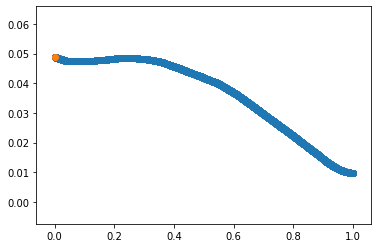

In [345]:
plt.scatter(nm(x),nm(model.pred_unce(x)))
plt.scatter([nm(x)[676]],[nm(model.pred_unce(x))[676]])

## sample 4 layer NN

In [330]:
model.pred_unce(x).shape

torch.Size([10000])

In [ ]:
class AbstModel(object):
    def __init__(self):
        pass
    def train(self,x,y):
        

In [162]:
# -*- coding: utf-8 -*-
import torch


class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu).clamp(min=0)
        y_pred = self.linear3(h_relu2)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1, 100, 1

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3#1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(5000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 67.42161560058594
1 65.59263610839844
2 64.32106018066406
3 63.51132583618164
4 63.03296661376953
5 62.770145416259766
6 62.64735412597656
7 62.635833740234375
8 62.70518112182617
9 62.79201889038086
10 62.82532501220703
11 62.78036117553711
12 62.6717529296875
13 62.53733825683594
14 62.40791702270508
15 62.303993225097656
16 62.23051834106445
17 62.181400299072266
18 62.159420013427734
19 62.162078857421875
20 62.1696891784668
21 62.1687126159668
22 62.15387725830078
23 62.1269416809082
24 62.08833312988281
25 62.0393180847168
26 61.984832763671875
27 61.933563232421875
28 61.890567779541016
29 61.855098724365234
30 61.831661224365234
31 61.81317901611328
32 61.79389190673828
33 61.772640228271484
34 61.7484130859375
35 61.72257614135742
36 61.69601058959961
37 61.66634750366211
38 61.63682174682617
39 61.608089447021484
40 61.58163070678711
41 61.560325622558594
42 61.53896713256836
43 61.51579666137695
44 61.49031066894531
45 61.462181091308594
46 61.43299865722656
47 61.40291976

489 50.7216796875
490 50.71465301513672
491 50.712005615234375
492 50.72341537475586
493 50.73292541503906
494 50.71066665649414
495 50.676143646240234
496 50.66057586669922
497 50.66522216796875
498 50.66569900512695
499 50.6710319519043
500 50.67257308959961
501 50.66132736206055
502 50.63285827636719
503 50.61368942260742
504 50.61775207519531
505 50.62885665893555
506 50.64327621459961
507 50.632972717285156
508 50.60527420043945
509 50.58684158325195
510 50.57257843017578
511 50.57091522216797
512 50.57455825805664
513 50.5729866027832
514 50.57218933105469
515 50.55198669433594
516 50.52973175048828
517 50.529972076416016
518 50.525901794433594
519 50.52468490600586
520 50.51317596435547
521 50.50273513793945
522 50.50590133666992
523 50.49762725830078
524 50.485816955566406
525 50.46435546875
526 50.466705322265625
527 50.4715461730957
528 50.463470458984375
529 50.45303726196289
530 50.44657516479492
531 50.44110870361328
532 50.43898391723633
533 50.41808319091797
534 50.41806

860 48.73659133911133
861 48.729736328125
862 48.72731018066406
863 48.72043228149414
864 48.71620559692383
865 48.70924377441406
866 48.7051887512207
867 48.703826904296875
868 48.69842529296875
869 48.692752838134766
870 48.68782043457031
871 48.69199752807617
872 48.683773040771484
873 48.680503845214844
874 48.67523193359375
875 48.670166015625
876 48.66472244262695
877 48.65971755981445
878 48.66376876831055
879 48.66403579711914
880 48.6508903503418
881 48.63470458984375
882 48.6367073059082
883 48.631935119628906
884 48.629581451416016
885 48.628936767578125
886 48.62297439575195
887 48.623966217041016
888 48.62120819091797
889 48.62303924560547
890 48.627201080322266
891 48.61443328857422
892 48.60672378540039
893 48.60196304321289
894 48.5926399230957
895 48.583595275878906
896 48.57979965209961
897 48.58370590209961
898 48.57578659057617
899 48.570228576660156
900 48.566551208496094
901 48.56962203979492
902 48.563987731933594
903 48.561241149902344
904 48.55009078979492
905 

1228 47.00032424926758
1229 47.00919723510742
1230 47.05339431762695
1231 47.07465362548828
1232 47.08140563964844
1233 47.06159591674805
1234 47.020267486572266
1235 46.97166061401367
1236 46.933982849121094
1237 46.91887664794922
1238 46.91681671142578
1239 46.9456787109375
1240 46.96094512939453
1241 46.9693489074707
1242 46.93353271484375
1243 46.92021179199219
1244 46.895263671875
1245 46.89177703857422
1246 46.875919342041016
1247 46.8776741027832
1248 46.885250091552734
1249 46.89298629760742
1250 46.88667678833008
1251 46.891910552978516
1252 46.8807373046875
1253 46.86128234863281
1254 46.846580505371094
1255 46.824981689453125
1256 46.81836700439453
1257 46.8364372253418
1258 46.847381591796875
1259 46.8499870300293
1260 46.86404800415039
1261 46.874847412109375
1262 46.84778594970703
1263 46.79997253417969
1264 46.79607391357422
1265 46.78374481201172
1266 46.76596450805664
1267 46.766815185546875
1268 46.747161865234375
1269 46.76142120361328
1270 46.770992279052734
1271 46

1595 45.13947296142578
1596 45.13842010498047
1597 45.131473541259766
1598 45.1297721862793
1599 45.13615036010742
1600 45.13492965698242
1601 45.12323760986328
1602 45.111114501953125
1603 45.09770965576172
1604 45.1041374206543
1605 45.09197235107422
1606 45.09130096435547
1607 45.080116271972656
1608 45.076717376708984
1609 45.07494354248047
1610 45.081233978271484
1611 45.069610595703125
1612 45.06157302856445
1613 45.06722640991211
1614 45.06705856323242
1615 45.061893463134766
1616 45.066749572753906
1617 45.075199127197266
1618 45.07640075683594
1619 45.07423400878906
1620 45.074684143066406
1621 45.09782791137695
1622 45.122318267822266
1623 45.110755920410156
1624 45.09553909301758
1625 45.06985855102539
1626 45.06704330444336
1627 45.05979537963867
1628 45.03409957885742
1629 45.0063362121582
1630 44.9898567199707
1631 44.989952087402344
1632 44.98628616333008
1633 44.98598861694336
1634 44.97727966308594
1635 44.95904541015625
1636 44.95430374145508
1637 44.94718551635742
16

1960 43.74530792236328
1961 43.76129150390625
1962 43.80501937866211
1963 43.825382232666016
1964 43.84114456176758
1965 43.80997848510742
1966 43.74400329589844
1967 43.659324645996094
1968 43.622642517089844
1969 43.596473693847656
1970 43.600120544433594
1971 43.62408447265625
1972 43.652225494384766
1973 43.66960144042969
1974 43.675086975097656
1975 43.676517486572266
1976 43.65673065185547
1977 43.62791061401367
1978 43.598426818847656
1979 43.57394027709961
1980 43.557708740234375
1981 43.55829620361328
1982 43.57172393798828
1983 43.57947540283203
1984 43.61056137084961
1985 43.63441848754883
1986 43.63798904418945
1987 43.61930847167969
1988 43.5906867980957
1989 43.564144134521484
1990 43.53423309326172
1991 43.51907730102539
1992 43.51068115234375
1993 43.51093292236328
1994 43.52261734008789
1995 43.5377082824707
1996 43.547115325927734
1997 43.550350189208984
1998 43.555843353271484
1999 43.54893493652344
2000 43.5335578918457
2001 43.51585388183594
2002 43.497802734375
20

2330 42.4075813293457
2331 42.40924072265625
2332 42.41816711425781
2333 42.42930221557617
2334 42.435691833496094
2335 42.435909271240234
2336 42.45273971557617
2337 42.44971466064453
2338 42.42868423461914
2339 42.39536666870117
2340 42.36708068847656
2341 42.352352142333984
2342 42.347618103027344
2343 42.35057830810547
2344 42.348480224609375
2345 42.368080139160156
2346 42.37991714477539
2347 42.41388702392578
2348 42.43936538696289
2349 42.47119140625
2350 42.49184036254883
2351 42.488033294677734
2352 42.472869873046875
2353 42.446842193603516
2354 42.41377258300781
2355 42.374603271484375
2356 42.346229553222656
2357 42.334293365478516
2358 42.314395904541016
2359 42.30547332763672
2360 42.296913146972656
2361 42.293880462646484
2362 42.28970718383789
2363 42.29636764526367
2364 42.31473159790039
2365 42.31245040893555
2366 42.32306671142578
2367 42.32792663574219
2368 42.34080123901367
2369 42.3355827331543
2370 42.32585525512695
2371 42.3211555480957
2372 42.30864334106445
23

2690 41.39818572998047
2691 41.394596099853516
2692 41.390628814697266
2693 41.39723587036133
2694 41.39898681640625
2695 41.40707778930664
2696 41.42009353637695
2697 41.44917297363281
2698 41.48002624511719
2699 41.53896713256836
2700 41.58769607543945
2701 41.63854217529297
2702 41.65872573852539
2703 41.65789031982422
2704 41.59841537475586
2705 41.492958068847656
2706 41.401023864746094
2707 41.35714340209961
2708 41.35875701904297
2709 41.416812896728516
2710 41.487220764160156
2711 41.52556610107422
2712 41.51834487915039
2713 41.46384811401367
2714 41.42176818847656
2715 41.37890625
2716 41.350189208984375
2717 41.34259796142578
2718 41.35580825805664
2719 41.3813591003418
2720 41.399471282958984
2721 41.406883239746094
2722 41.39547348022461
2723 41.36851501464844
2724 41.3464241027832
2725 41.33245849609375
2726 41.314022064208984
2727 41.3088264465332
2728 41.316680908203125
2729 41.31940460205078
2730 41.322975158691406
2731 41.332496643066406
2732 41.366310119628906
2733 4

3048 40.589073181152344
3049 40.587982177734375
3050 40.589603424072266
3051 40.59447479248047
3052 40.602840423583984
3053 40.611854553222656
3054 40.61699295043945
3055 40.621395111083984
3056 40.6135368347168
3057 40.625267028808594
3058 40.62868881225586
3059 40.631919860839844
3060 40.6195182800293
3061 40.61394500732422
3062 40.616249084472656
3063 40.6256217956543
3064 40.623870849609375
3065 40.62584686279297
3066 40.61278533935547
3067 40.59796142578125
3068 40.5833854675293
3069 40.58589172363281
3070 40.57566833496094
3071 40.57365417480469
3072 40.57208251953125
3073 40.575599670410156
3074 40.579349517822266
3075 40.58705520629883
3076 40.584716796875
3077 40.579376220703125
3078 40.57012939453125
3079 40.571533203125
3080 40.56065368652344
3081 40.54468536376953
3082 40.53296661376953
3083 40.51737976074219
3084 40.505409240722656
3085 40.4962158203125
3086 40.49800109863281
3087 40.49140548706055
3088 40.49068069458008
3089 40.49942398071289
3090 40.50368118286133
3091 4

3410 39.850460052490234
3411 39.85285949707031
3412 39.84766387939453
3413 39.847713470458984
3414 39.843421936035156
3415 39.857322692871094
3416 39.843814849853516
3417 39.85106658935547
3418 39.85970687866211
3419 39.86435317993164
3420 39.8586540222168
3421 39.853355407714844
3422 39.85329818725586
3423 39.852500915527344
3424 39.84108352661133
3425 39.824310302734375
3426 39.80516815185547
3427 39.792762756347656
3428 39.789119720458984
3429 39.78597640991211
3430 39.77914810180664
3431 39.77035140991211
3432 39.78274917602539
3433 39.80934524536133
3434 39.79106903076172
3435 39.793853759765625
3436 39.78589630126953
3437 39.77660369873047
3438 39.76342010498047
3439 39.76327133178711
3440 39.764530181884766
3441 39.76089859008789
3442 39.75849151611328
3443 39.75360107421875
3444 39.77925491333008
3445 39.81935501098633
3446 39.82032775878906
3447 39.83108901977539
3448 39.852298736572266
3449 39.86762237548828
3450 39.89410400390625
3451 39.90913391113281
3452 39.90664672851562

3775 39.2087287902832
3776 39.241973876953125
3777 39.274383544921875
3778 39.28639221191406
3779 39.253379821777344
3780 39.18076705932617
3781 39.117435455322266
3782 39.09649658203125
3783 39.11984634399414
3784 39.160850524902344
3785 39.18770980834961
3786 39.200599670410156
3787 39.19314956665039
3788 39.20442199707031
3789 39.18882369995117
3790 39.1370849609375
3791 39.085975646972656
3792 39.07368469238281
3793 39.08903121948242
3794 39.10835266113281
3795 39.11200714111328
3796 39.13051986694336
3797 39.13618087768555
3798 39.159542083740234
3799 39.170799255371094
3800 39.12677764892578
3801 39.09843063354492
3802 39.08169174194336
3803 39.08061981201172
3804 39.07016372680664
3805 39.04685592651367
3806 39.05878829956055
3807 39.078834533691406
3808 39.07487106323242
3809 39.05985641479492
3810 39.05760192871094
3811 39.059635162353516
3812 39.05839920043945
3813 39.04917526245117
3814 39.040931701660156
3815 39.02766799926758
3816 39.05635452270508
3817 39.07279968261719
3

4136 38.43284606933594
4137 38.40316390991211
4138 38.388404846191406
4139 38.40232849121094
4140 38.38328552246094
4141 38.383018493652344
4142 38.39133834838867
4143 38.3950080871582
4144 38.39695739746094
4145 38.40562438964844
4146 38.41902542114258
4147 38.44343948364258
4148 38.4857063293457
4149 38.532108306884766
4150 38.611358642578125
4151 38.667564392089844
4152 38.66749954223633
4153 38.67255401611328
4154 38.64215087890625
4155 38.60774230957031
4156 38.55979537963867
4157 38.499141693115234
4158 38.444759368896484
4159 38.39360046386719
4160 38.362606048583984
4161 38.34892272949219
4162 38.340171813964844
4163 38.36379623413086
4164 38.391300201416016
4165 38.44589614868164
4166 38.498695373535156
4167 38.519676208496094
4168 38.521728515625
4169 38.48606872558594
4170 38.45667266845703
4171 38.38908767700195
4172 38.349613189697266
4173 38.32829284667969
4174 38.327510833740234
4175 38.337703704833984
4176 38.359622955322266
4177 38.38812255859375
4178 38.42710494995117

4500 37.84856414794922
4501 37.92504119873047
4502 37.964027404785156
4503 37.953163146972656
4504 37.87757110595703
4505 37.8159065246582
4506 37.75309753417969
4507 37.72098922729492
4508 37.71451950073242
4509 37.73356246948242
4510 37.740535736083984
4511 37.76715850830078
4512 37.76287841796875
4513 37.74311828613281
4514 37.723934173583984
4515 37.71530532836914
4516 37.70173645019531
4517 37.708343505859375
4518 37.72947311401367
4519 37.703792572021484
4520 37.70009994506836
4521 37.70143508911133
4522 37.69401168823242
4523 37.68051528930664
4524 37.68766784667969
4525 37.71559524536133
4526 37.683162689208984
4527 37.69419479370117
4528 37.70430374145508
4529 37.69706726074219
4530 37.68854522705078
4531 37.725772857666016
4532 37.686527252197266
4533 37.68775177001953
4534 37.685752868652344
4535 37.68069076538086
4536 37.69461441040039
4537 37.670902252197266
4538 37.672611236572266
4539 37.66046905517578
4540 37.661495208740234
4541 37.65787124633789
4542 37.67427825927734

4861 37.25809097290039
4862 37.23378372192383
4863 37.218257904052734
4864 37.201385498046875
4865 37.17811965942383
4866 37.168304443359375
4867 37.16460037231445
4868 37.166263580322266
4869 37.1413459777832
4870 37.14796829223633
4871 37.14591598510742
4872 37.14414978027344
4873 37.13869857788086
4874 37.153690338134766
4875 37.13703536987305
4876 37.14069366455078
4877 37.14675521850586
4878 37.1609001159668
4879 37.1685791015625
4880 37.21284866333008
4881 37.24527359008789
4882 37.26798629760742
4883 37.316612243652344
4884 37.306251525878906
4885 37.32453155517578
4886 37.325862884521484
4887 37.32616424560547
4888 37.37034606933594
4889 37.36170959472656
4890 37.389400482177734
4891 37.448177337646484
4892 37.50532531738281
4893 37.51167678833008
4894 37.457942962646484
4895 37.36696243286133
4896 37.29066848754883
4897 37.20038986206055
4898 37.141422271728516
4899 37.134765625
4900 37.12814712524414
4901 37.1142463684082
4902 37.122982025146484
4903 37.14787292480469
4904 37

In [163]:
y_hat = model(x).detach().numpy()

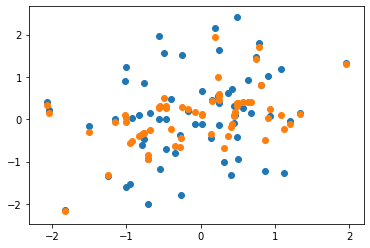

In [164]:
plt.scatter(x.detach().numpy(),y.detach().numpy())
plt.scatter(x.detach().numpy(),y_hat)

In [139]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1000, 1, 100, 1

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3#1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(5000):
    x, y = get_data(target_function1,N)
    x = torch.tensor(x, dtype=torch.float).view(N,1,1)
    y = torch.tensor(y, dtype=torch.float).view(N,1,1)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 220.29873657226562
1 215.9100341796875
2 227.00155639648438
3 202.3939208984375
4 219.22113037109375
5 229.09039306640625
6 228.87599182128906
7 216.0721435546875
8 211.86521911621094
9 228.7318878173828
10 208.8097381591797
11 214.37127685546875
12 214.74037170410156
13 210.27032470703125
14 214.6842803955078
15 220.7592315673828
16 217.05616760253906
17 206.83209228515625
18 222.4735870361328
19 205.81260681152344
20 205.78147888183594
21 219.55181884765625
22 203.50743103027344
23 217.19631958007812
24 211.6715850830078
25 219.51060485839844
26 207.75662231445312
27 213.80606079101562
28 215.03663635253906
29 211.5015106201172
30 227.32806396484375
31 224.84310913085938
32 202.99996948242188
33 218.66949462890625
34 205.1644744873047
35 224.75363159179688
36 218.44662475585938
37 202.87261962890625
38 209.19912719726562
39 220.3845977783203
40 217.35012817382812
41 221.74156188964844
42 211.11834716796875
43 212.45970153808594
44 216.52183532714844
45 217.84056091308594
46 213.477

427 127.6302490234375
428 134.69004821777344
429 128.420654296875
430 123.13005828857422
431 138.76327514648438
432 127.86137390136719
433 128.2036590576172
434 121.70053100585938
435 123.61058807373047
436 128.5633087158203
437 129.7764434814453
438 114.51021575927734
439 121.02003479003906
440 121.95586395263672
441 124.41706848144531
442 125.3646240234375
443 123.45882415771484
444 129.8278045654297
445 118.82611083984375
446 125.13121032714844
447 122.477294921875
448 121.96014404296875
449 132.78382873535156
450 128.4615478515625
451 127.25013732910156
452 127.24949645996094
453 121.99890899658203
454 128.81353759765625
455 124.35874938964844
456 121.23129272460938
457 119.63847351074219
458 119.28919982910156
459 124.20014190673828
460 118.63227081298828
461 123.62467193603516
462 118.2984390258789
463 125.51002502441406
464 121.86860656738281
465 116.1589584350586
466 120.10563659667969
467 120.09568786621094
468 115.90264129638672
469 118.39942169189453
470 112.23497009277344
4

849 78.65469360351562
850 71.88872528076172
851 72.19074249267578
852 75.61640930175781
853 76.0017318725586
854 77.9620132446289
855 72.2056655883789
856 70.21350860595703
857 68.71631622314453
858 68.9031982421875
859 72.8281021118164
860 75.8856430053711
861 73.49744415283203
862 69.97655487060547
863 71.23103332519531
864 75.21003723144531
865 68.37256622314453
866 73.58041381835938
867 71.87926483154297
868 71.6986312866211
869 68.73681640625
870 70.01238250732422
871 77.63810729980469
872 67.22982788085938
873 73.161376953125
874 69.02823638916016
875 71.42300415039062
876 71.93688201904297
877 72.69743347167969
878 64.38825988769531
879 72.84546661376953
880 78.45164489746094
881 69.61022186279297
882 72.78025817871094
883 70.1871337890625
884 67.56051635742188
885 71.95002746582031
886 65.52606964111328
887 72.63494110107422
888 67.29241943359375
889 70.726806640625
890 73.43296813964844
891 74.0379638671875
892 73.4261703491211
893 70.39041900634766
894 71.17510986328125
895 6

1269 45.71986389160156
1270 46.40242385864258
1271 47.73211669921875
1272 42.93058395385742
1273 46.17536163330078
1274 45.53468704223633
1275 50.234619140625
1276 48.812496185302734
1277 47.91877746582031
1278 42.639949798583984
1279 45.957332611083984
1280 43.12289047241211
1281 44.15792465209961
1282 48.44758224487305
1283 42.45585250854492
1284 47.862586975097656
1285 43.13890838623047
1286 44.41384506225586
1287 43.356746673583984
1288 41.60661697387695
1289 47.985198974609375
1290 45.08541488647461
1291 48.00313186645508
1292 44.99228286743164
1293 51.366859436035156
1294 46.70112228393555
1295 44.92209243774414
1296 46.152320861816406
1297 44.75282669067383
1298 42.772918701171875
1299 49.015201568603516
1300 44.804718017578125
1301 47.295101165771484
1302 46.02426528930664
1303 45.480323791503906
1304 41.0886116027832
1305 49.98073196411133
1306 43.2445068359375
1307 45.064762115478516
1308 41.7465705871582
1309 43.809146881103516
1310 48.97489929199219
1311 46.049678802490234


1690 22.216922760009766
1691 19.674659729003906
1692 23.156702041625977
1693 21.55086898803711
1694 22.359188079833984
1695 22.155725479125977
1696 20.81459617614746
1697 20.95379066467285
1698 23.158552169799805
1699 22.05414390563965
1700 23.973447799682617
1701 23.295093536376953
1702 21.61949348449707
1703 21.28126335144043
1704 23.581247329711914
1705 20.594100952148438
1706 20.396081924438477
1707 21.849590301513672
1708 22.158248901367188
1709 24.33803939819336
1710 23.992725372314453
1711 19.986656188964844
1712 21.337900161743164
1713 21.31692123413086
1714 20.29250717163086
1715 21.243770599365234
1716 23.140836715698242
1717 22.28965950012207
1718 18.239246368408203
1719 21.955902099609375
1720 20.55483055114746
1721 20.387248992919922
1722 24.80351448059082
1723 23.010066986083984
1724 22.167522430419922
1725 29.631845474243164
1726 26.528644561767578
1727 20.498510360717773
1728 25.570817947387695
1729 18.799413681030273
1730 24.062774658203125
1731 22.444730758666992
1732

2043 12.435342788696289
2044 11.820526123046875
2045 10.682168960571289
2046 11.328607559204102
2047 11.203697204589844
2048 10.851482391357422
2049 10.887238502502441
2050 11.200921058654785
2051 10.319498062133789
2052 11.198575019836426
2053 10.037399291992188
2054 10.366147994995117
2055 11.249897956848145
2056 11.393180847167969
2057 11.156025886535645
2058 10.59762954711914
2059 10.810873985290527
2060 10.828081130981445
2061 11.639803886413574
2062 10.623283386230469
2063 10.397130966186523
2064 9.905613899230957
2065 11.78138256072998
2066 11.485372543334961
2067 11.185041427612305
2068 10.89215087890625
2069 11.026446342468262
2070 9.543983459472656
2071 11.301909446716309
2072 10.848587036132812
2073 10.518465042114258
2074 10.0078706741333
2075 9.012228012084961
2076 10.518632888793945
2077 9.975500106811523
2078 9.399456977844238
2079 9.832531929016113
2080 10.197571754455566
2081 9.214109420776367
2082 9.739982604980469
2083 11.115928649902344
2084 11.086518287658691
2085 

2469 8.598504066467285
2470 6.014979839324951
2471 4.551388263702393
2472 4.987184047698975
2473 5.839048385620117
2474 5.677060127258301
2475 4.630406379699707
2476 5.086359024047852
2477 6.022095203399658
2478 4.493137359619141
2479 4.848874092102051
2480 5.299488067626953
2481 5.994362831115723
2482 5.297380447387695
2483 4.34075403213501
2484 4.704103469848633
2485 5.354635715484619
2486 4.709123134613037
2487 4.183802127838135
2488 5.027898788452148
2489 4.959268569946289
2490 4.58465051651001
2491 4.748090744018555
2492 5.303254127502441
2493 4.9871439933776855
2494 4.61624813079834
2495 4.082046031951904
2496 4.661092281341553
2497 4.6118550300598145
2498 4.600890159606934
2499 4.493598461151123
2500 4.61780309677124
2501 4.138797760009766
2502 4.794652938842773
2503 4.946677207946777
2504 5.065642833709717
2505 4.295317649841309
2506 3.976386547088623
2507 4.3683247566223145
2508 4.861390590667725
2509 4.746786594390869
2510 4.428708076477051
2511 4.687942981719971
2512 4.80013

2900 2.0989413261413574
2901 2.1691622734069824
2902 2.2609028816223145
2903 2.204306125640869
2904 2.178422451019287
2905 2.074376344680786
2906 2.240907669067383
2907 2.115687847137451
2908 2.1357810497283936
2909 2.2232155799865723
2910 2.119990110397339
2911 2.1492867469787598
2912 2.421022891998291
2913 2.3013830184936523
2914 2.253444194793701
2915 2.3659563064575195
2916 2.2173337936401367
2917 2.1641268730163574
2918 2.207170009613037
2919 2.363304376602173
2920 2.375962495803833
2921 2.249800205230713
2922 2.165325880050659
2923 2.1433961391448975
2924 2.0945963859558105
2925 2.2874834537506104
2926 2.187000274658203
2927 2.153069496154785
2928 2.424915075302124
2929 2.7830891609191895
2930 2.564321517944336
2931 2.492288112640381
2932 2.4490833282470703
2933 2.031810998916626
2934 2.1909146308898926
2935 2.1515557765960693
2936 2.0329039096832275
2937 1.9360816478729248
2938 2.27217960357666
2939 2.1357922554016113
2940 2.4796669483184814
2941 2.4794511795043945
2942 2.305526

3319 1.7650927305221558
3320 1.6425738334655762
3321 1.2960137128829956
3322 1.3055773973464966
3323 1.3427822589874268
3324 1.487722635269165
3325 1.2386338710784912
3326 1.3357182741165161
3327 1.240942358970642
3328 1.4233827590942383
3329 1.7484803199768066
3330 1.8050659894943237
3331 1.774997353553772
3332 1.6742777824401855
3333 1.352333903312683
3334 1.3858369588851929
3335 1.3241242170333862
3336 1.4163604974746704
3337 1.3720791339874268
3338 1.3396267890930176
3339 1.5194008350372314
3340 1.7771368026733398
3341 2.0000178813934326
3342 1.9982044696807861
3343 1.6313579082489014
3344 1.4116697311401367
3345 1.2948576211929321
3346 1.4096585512161255
3347 1.5268161296844482
3348 1.4469636678695679
3349 1.2908700704574585
3350 1.3539278507232666
3351 1.893053650856018
3352 2.1951904296875
3353 1.927833914756775
3354 1.5555682182312012
3355 1.1820847988128662
3356 1.2993160486221313
3357 1.7264585494995117
3358 2.4820170402526855
3359 3.371753215789795
3360 3.917740821838379
336

3678 2.0540413856506348
3679 1.4440771341323853
3680 1.0996187925338745
3681 1.0014394521713257
3682 1.1836228370666504
3683 1.8729745149612427
3684 2.8006224632263184
3685 3.6648197174072266
3686 4.346287250518799
3687 4.243714332580566
3688 3.6024792194366455
3689 2.1434121131896973
3690 1.2603530883789062
3691 0.7976987957954407
3692 1.286821961402893
3693 1.7098392248153687
3694 2.28132963180542
3695 2.497838258743286
3696 2.2081663608551025
3697 1.594079613685608
3698 1.10847806930542
3699 0.9523949027061462
3700 0.8885672688484192
3701 1.046852469444275
3702 1.4039937257766724
3703 1.4853821992874146
3704 1.7463605403900146
3705 1.4075429439544678
3706 1.04836905002594
3707 0.9343934059143066
3708 1.2264775037765503
3709 1.8345433473587036
3710 2.670213222503662
3711 3.244791269302368
3712 3.3575613498687744
3713 2.937669277191162
3714 2.0783591270446777
3715 1.194514513015747
3716 0.943244993686676
3717 1.1401395797729492
3718 1.994919776916504
3719 2.549063205718994
3720 2.4314

4040 0.6240499019622803
4041 0.6928022503852844
4042 0.6063846945762634
4043 0.7196965217590332
4044 0.5608272552490234
4045 0.5736135244369507
4046 0.6082860231399536
4047 0.6640024781227112
4048 0.6434295773506165
4049 0.6629455089569092
4050 0.9175961017608643
4051 1.2181074619293213
4052 1.393689751625061
4053 1.4552299976348877
4054 1.4108948707580566
4055 1.4520128965377808
4056 1.6793872117996216
4057 1.57290518283844
4058 1.5296425819396973
4059 1.3841825723648071
4060 1.1167386770248413
4061 0.8338028192520142
4062 0.7023058533668518
4063 0.5643129348754883
4064 0.6465907692909241
4065 0.7054234743118286
4066 0.8883498311042786
4067 1.135636568069458
4068 1.300498127937317
4069 1.2390738725662231
4070 1.1702046394348145
4071 0.9402515292167664
4072 0.7596362829208374
4073 0.7716934680938721
4074 0.689610481262207
4075 0.6999987959861755
4076 0.6626119613647461
4077 0.6428204774856567
4078 0.6470978856086731
4079 0.7124055027961731
4080 0.8084862232208252
4081 1.093258976936340

4450 0.7101883888244629
4451 0.6527710556983948
4452 0.6135821342468262
4453 0.6262056231498718
4454 0.5313883423805237
4455 0.45615121722221375
4456 0.4659477174282074
4457 0.5869710445404053
4458 0.7777404189109802
4459 0.95931077003479
4460 1.006928563117981
4461 0.956041157245636
4462 0.8325026631355286
4463 0.7010365128517151
4464 0.759505033493042
4465 0.7772670984268188
4466 0.7228786945343018
4467 0.6983675956726074
4468 0.7230418920516968
4469 0.795365035533905
4470 0.8486914038658142
4471 0.9387032985687256
4472 1.0555557012557983
4473 1.0809165239334106
4474 1.104171633720398
4475 1.0756094455718994
4476 1.0527845621109009
4477 1.0761981010437012
4478 1.0634520053863525
4479 1.0337132215499878
4480 1.0125337839126587
4481 0.927907407283783
4482 0.9952825307846069
4483 0.7280129194259644
4484 0.6973119974136353
4485 0.6265623569488525
4486 0.5634043216705322
4487 0.5646236538887024
4488 0.4511561989784241
4489 0.5388942956924438
4490 0.4197818636894226
4491 0.4940198361873626

4881 0.8667089939117432
4882 0.8712553977966309
4883 0.9262784719467163
4884 0.815497875213623
4885 0.7578443288803101
4886 0.6541934013366699
4887 0.550003707408905
4888 0.46663033962249756
4889 0.40244749188423157
4890 0.33262133598327637
4891 0.3275435268878937
4892 0.3723740875720978
4893 0.36455807089805603
4894 0.4063035547733307
4895 0.4441053569316864
4896 0.5741209387779236
4897 0.6974049806594849
4898 0.7955520153045654
4899 0.8433911800384521
4900 0.8784549236297607
4901 0.8559378385543823
4902 0.7335970997810364
4903 0.6677355766296387
4904 0.5825499296188354
4905 0.4755241572856903
4906 0.3924940526485443
4907 0.3364105522632599
4908 0.35380819439888
4909 0.4155033826828003
4910 0.37704232335090637
4911 0.34920215606689453
4912 0.32188698649406433
4913 0.3483656346797943
4914 0.34709233045578003
4915 0.3803301155567169
4916 0.40308740735054016
4917 0.5901548862457275
4918 0.8635429739952087
4919 1.2108047008514404
4920 1.780319333076477
4921 2.4217629432678223
4922 2.89638

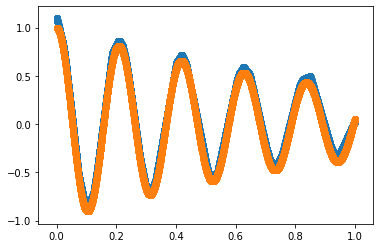

In [142]:
(np.power(y - y_hat,2)).mean()

0.4363535316606876